# Pairs Trading Enhancements

By Sam Galita and James Zhang |  Smith Investment Fund  |  Spring 2023

<hr/>

# Introduction

Pairs trading is a type of mean reversion trading strategy first introduced by technical analyst researchers at Morgan Stanley in the mid-1980s. On a high level, pairs trading involves matching a long position with a short position in two highly cointegrated stocks. A statistical tool often used in timeseries analysis, cointegration measures the degree to which two time series' means trend together. In pairs trading, we apply cointegration on the difference of prices between two stocks, otherwise known as the spread, to detect assets that tend to trend similarly. 

One of the main advantages of this strategy is market neutrality. Since traders are trading the spread between two assets and not individual assets, a pairs trader can find statistical arbitrage opportunities regardless of market direction. In other words, we should not expect better or worse performance during economic downswings. Furthermore, traders remain delta neutral when using this strategy, making pairs trading relatively low risk, and theoretically less volatile than a market-following strategy. As a result of this risk advantage, many hedge funds have historically leveraged pairs trading, despite it's low relative returns. However, this strategy is widely known in the modern market and would likely not provide high returns in a real market setting. Despite this, pairs trading sets the groundwork for further research into statistical arbitrage and remains an interesting topic for research.

After two cointegrated stocks are identified, if a cointegration discrepancy occurs - when the spread between two securities diverges from their historical rolling mean and beyond some threshold - the trader invests a dollar-matched long position in the underperforming security and short position in the overperforming security. If the spread between these assets does indeed reconverge, which is expected due to the identified relationship between pairs, traders will make a profit.

One of the keys to successful pairs trading is being able to efficiently detect pairs. In a notebook published a few months ago, Abhi designed and applied a basic pais trading strategy to the equity and crypto markets. In our notebook, we propose enhancements to last semester's pairs trading work done by Abhi. First, we will apply Principal Component Analysis (PCA) and clustering to the pricing timeseries, exploring a variety of clustering methods in the process. Within each cluster, we will then perform cointegration tests to identify pairs. Because of the use of clustering and PCA, we expect to find a reduction in needed computation time, thus allowing us to use a larger universe size when backtesting, which theoretically will allow us to compute more profitable pairs. 

Furthermore, we will also explore a variety of parameter optimizations for the strategy, specifically with respect to lookback, reset frequency of pair selection, and zscore cutoffs. Lastly, we will also explore the idea of using the other validation techniques as an additional criteria for selecting profitable pairs.


## Required Imports

Below is some more information about some of the more fundamental libraries if you want to learn more.

- <a href="https://numpy.org/doc/">NumPy</a>
- <a href="https://pandas.pydata.org/docs/">Pandas</a>
- <a href="https://matplotlib.org/stable/index.html">Matplotlib</a>
- <a href="https://scikit-learn.org/stable/index.html">Sklearn</a>
- <a href="https://www.statsmodels.org/stable/index.html">Statsmodels</a>

In [1]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import random
import time
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, OPTICS
from sklearn.neighbors import NearestNeighbors
from statsmodels.tsa.stattools import coint
from IPython.core import display as ICD
from collections import Counter
from typing import Dict, List, Tuple, Union
array_1d = Union[List, Tuple, pd.Series, np.ndarray]
date_obj = Union[datetime.datetime, datetime.date]
import requests
from urllib.request import urlopen, Request
import bs4 as bs
import functools
import warnings
warnings.filterwarnings('ignore')  # Disable warnings to reduce output spam in notebook
from sif.siftools.backtesters import full_backtesters as fb
from sif.siftools import operators as op
from sif.siftools import metrics as metrics
from sif.sifinfra import sif_utils as su
from sif.siftools.abstractalpha import AbstractAlpha
from sif.sifinsights import alpha_search
from sif.sifinsights.alpha_search import apply_metric_func

We initialize multiple backtesters from the SIF Infrastructure that will allow us to test our pairs trading strategies in sample from $2000-2015$ and out of sample from $2016-2020$. Note that we can save them locally to save time each time we want to test our alphas.

In [2]:
# *** IN SAMPLE BACKTESTER WITH UNIVERSE REBALANCING *** #
start_date_15y = datetime.datetime(2000, 1, 1)
end_date_15y = datetime.datetime(2015, 12, 31)
# backtester_15y = fb.FullMultipleBacktester(
#     start_date_15y,
#     end_date_15y,
#     'M',
#     273,
#     universe_size = 500, 
#     factors=['close', 'sector']
# )
# backtester_15y.save_local('pairs_15y.npy')
backtester_15y = fb.FullMultipleBacktester.from_local('pairs\pairs_15y.npy')

In [3]:
# *** OUT OF SAMPLE BACKTESTER WITH UNIVERSE REBALANCING *** #
start_date_5y = datetime.datetime(2016, 1, 1)
end_date_5y = datetime.datetime(2020, 12, 31)
# backtester_5y = fb.FullMultipleBacktester(
#     start_date_5y,
#     end_date_5y,
#     'M',
#     273,
#     universe_size = 500, 
#     factors=['close', 'sector']
# )
# backtester_5y.save_local('pairs_5y.npy')
backtester_5y = fb.FullMultipleBacktester.from_local('pairs\pairs_5y.npy')

In [5]:
# *** GET ROLLING SHARPE RATIO HELPER FUNCTION *** #
def get_rolling_sharpe(returns):
    rolling_sharpe = functools.partial(metrics.rolling_metric, func=metrics.sharpe_ratio, window=252)
    returns.apply(rolling_sharpe).plot()
    plt.title('1 Year Rolling Sharpe Ratio')
    plt.show()

# *** GET OTHER SUMMARY ANALYTICS HELPER FUNCTION *** #
def get_analytics(alphas, returns, holdings):
    perf_tables = apply_metric_func(metrics.generate_performance_table, ('daily_returns', 'holdings'))(returns, holdings)
    for alpha, table in zip(alphas, perf_tables):
        print(f"{alpha.name}")
        ICD.display(table)
        print()

## Previous Work and Novelties

SIF Researcher Abhinav Modugula worked on pairs trading for much of last semester. Our work in this notebook builds on top of his initial research. You can read his work here: https://www.smithinvestmentfund.com/blog/crypto-pairs-trading. His initial work on pairs trading should be read before the rest of this notebook.

### Selecting Pairs and Weights

As a baseline metric, we present brute force pairs trading alphas without dimensionality reduction, machine learning enhancements, additional trading criteria, or parameter optimization. These alphas are based off of Abhi's original alphas, with notable fixes to certain bugs.

For both of the following alphas, we test for cointegration between the price time series of two securities using the `Statsmodels` implementation of the Engle-Granger Test, which outputs a pvalue that can be used to either accept or reject the null hypothesis that the two secrities are cointegrated. The first alpha takes all of the statistically significant pairs between the $50$ securities in the universe and randomly selects $10$ to trade off of. Extracting random pairs out of all the generated pairs can possibly be improved, however, by choosing the lowest pvalue pairs. The second alpha implements this idea. 


See the implementation below of the Random pairs trading strategy explained in the introduction. The Lowest Pvalue strategy - and all strategies testing in this blog post - can be found in the `alphas.py` file. 

Following all tests, we also created the `alphas_v2.py` file, which leverages inheritance to maximize alpha customizability. Note that while all alphas in this blog post can be implemented with the `PairsTrader` class in `alphas_v2.py`, we decided to include `alphas.py` as they include the alphas that we actually used in this notebook.

### Parameters

For this inital strategy, we rechoose pairs every $90$ days and select $10$ pairs to trade on. The universe size is $500$, and we enter trades when the magnitude of the zscore of the difference of prices is above $1.0$ and exit when it is below $0.5$.

In [6]:
class Random(AbstractAlpha):
    def __init__(self, reset: int, npairs: int, exit: int):
        self.name = 'Random'
        self.lookback = reset
        self.factor_list = ['close']
        self.universe_size = 500
        self.pairs = None
        self.print = True
        self.reset = reset
        self.npairs = npairs
        self.exit = exit
        self.holdings = np.zeros(self.universe_size)
        self.day_counter = 0
        self.count = 0
    
    def form_pairs(self, df: pd.DataFrame) -> List[Tuple]:
        df = pd.DataFrame(df)
        n = df.shape[1]
        pvalue_matrix = np.ones((n, n))
        keys = df.keys()
        pairs = []
        # Only consider 50 securities for convenience.
        for i in range(50):
            for j in range(i + 1, 50):
                # Isolate the two time series.
                S1 = df[keys[i]]
                S2 = df[keys[j]]
                coint_df = pd.DataFrame({'S1': S1, 'S2': S2}).dropna()
                S1 = coint_df['S1']
                S2 = coint_df['S2']
                # Perform the Engle-Granger Cointegration test.
                result = coint(S1, S2)
                pvalue = result[1]
                pvalue_matrix[i, j] = pvalue
                # Add it to our list of pairs if the null hypothesis is rejected.
                if pvalue < 0.05 and pvalue != 0:
                    pairs.append([i, j])
        # Remove duplicate stocks.
        new_pairs, seen = [], set()
        for (i, j) in pairs:
            if i not in seen and j not in seen:
                new_pairs.append([i, j])
                seen.add(i)
                seen.add(j)
        # Take a random npairs sample of pairs if there are that many.
        new_pairs = new_pairs if len(new_pairs) < self.npairs else random.sample(new_pairs, self.npairs)
        return new_pairs
    
    def zscore(self, series: pd.Series) -> pd.Series:
        return (series - series.mean()) / np.std(series)
        
    def generate_day(self, day: int, data: Dict[pd.DataFrame]) -> List[float]:
        # Create new pairs after 90 days.
        if self.day_counter == 0:
            self.day_counter = self.reset
            self.holdings = np.zeros(self.universe_size)
            self.pairs = self.form_pairs(data['close'])
        # Obtain just the close price data.
        data = pd.DataFrame(data['close'])
        global ex_data
        if self.print:
            ex_data = data
            self.print = False
        # Implement trading methodology for all of the pairs.
        for p in self.pairs:
            # FIRST and SECOND are indices of the stocks.
            FIRST, SECOND = p[0], p[1]
            spread = data[FIRST] - data[SECOND]
            # Zscore tells us how far from away from the mean a data point is.
            z_score = self.zscore(spread).tail(1).values[0]
            # Long SECOND, short FIRST.
            if z_score >= 1.0:
                self.holdings[FIRST] = -1
                self.holdings[SECOND] = 1
            # Exit the trade.
            elif abs(z_score) <= self.exit:
                self.holdings[FIRST] = 0
                self.holdings[SECOND] = 0
            # Long FIRST, short SECOND.
            elif z_score <= -1.0:
                self.holdings[FIRST] = 1
                self.holdings[SECOND] = -1
        # At the end of the trading day, decrement the day counter.
        self.day_counter -= 1
        return op.weight(self.holdings)

# Brute force Random Alphas

Lowest PValue: 100%|███████████████████████████████████████████████████████████████████| 2/2 [41:44<00:00, 1252.31s/it]


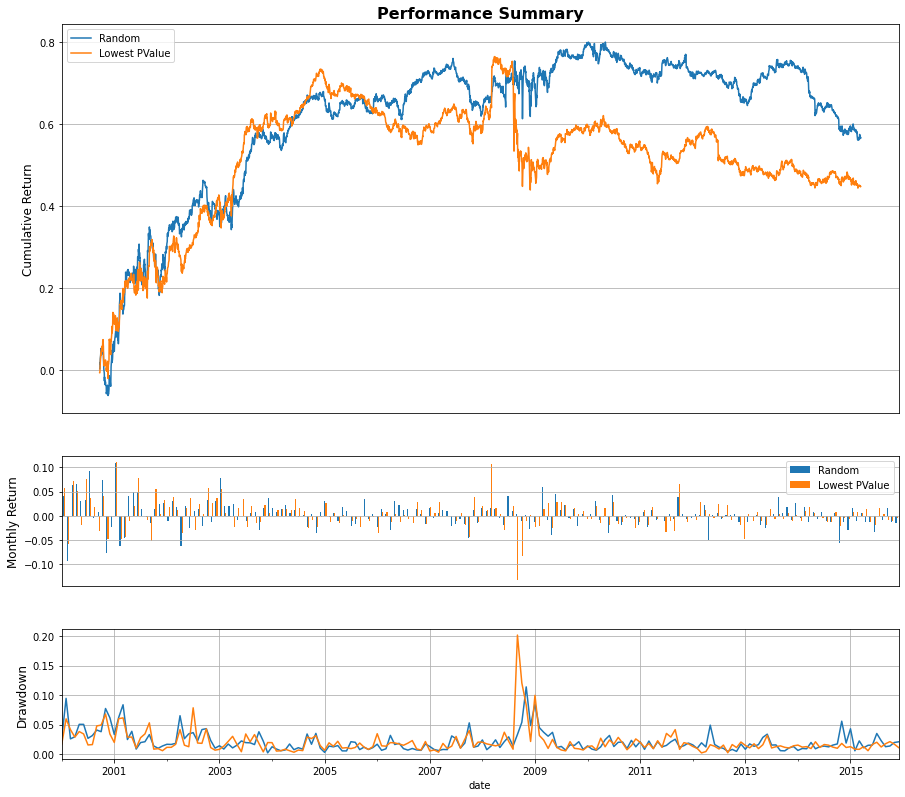

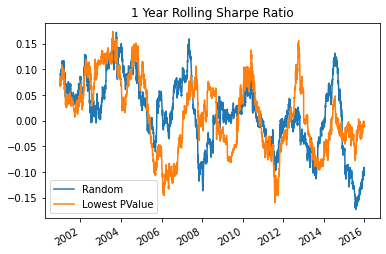

Random


return    sharpe   sortino  drawdown  turnover  long count  \
year                                                                    
2000     0.207453  1.174563  1.963932  0.121765  0.239281    7.619048   
2001     0.202416  1.374860  2.528090  0.156398  0.213678    6.915323   
2002     0.022599  0.220045  0.370776  0.116316  0.160217    7.829365   
2003     0.160865  2.250688  4.028547  0.050209  0.209675    7.317460   
2004     0.026769  0.496959  0.735897  0.065530  0.178387    7.583333   
2005     0.041413  0.748246  1.100838  0.045135  0.149815    7.674603   
2006     0.048512  0.864765  1.408391  0.050609  0.204894    7.179283   
2007    -0.069959 -1.340977 -1.981438  0.119681  0.169850    8.027888   
2008     0.052613  0.341559  0.554229  0.134916  0.174796    7.671937   
2009     0.071714  0.563247  0.756804  0.084621  0.185804    7.365079   
2010    -0.008909 -0.127753 -0.187538  0.052120  0.182052    7.182540   
2011    -0.008934 -0.161839 -0.254445  0.057651  0.185235    7.932540   
2012    -0.032322 -0.631351 -0.725496  0.058472  0.165895    8.076000   
2013     0.001257  0.024603  0.039814  0.073764  0.176279    7.424603   
2014    -0.051300 -0.945594 -1.246059  0.091580  0.163507    8.309524   
2015    -0.097226 -1.566235 -1.891560  0.099548  0.166688    7.912698   
Overall  0.566958  0.377770  0.547100  0.218711  0.223535    7.626832   

         short count  
year                  
2000        6.619048  
2001        5.915323  
2002        6.829365  
2003        6.317460  
2004        6.583333  
2005        6.674603  
2006        6.179283  
2007        7.027888  
2008        6.671937  
2009        6.365079  
2010        6.182540  
2011        6.932540  
2012        7.076000  
2013        6.424603  
2014        7.309524  
2015        6.912698  
Overall     6.626832


Lowest PValue


return    sharpe   sortino  drawdown  turnover  long count  \
year                                                                    
2000     0.194207  1.132443  1.844114  0.091796  0.225980    7.551587   
2001     0.135793  1.029168  1.714540  0.123996  0.187814    7.395161   
2002     0.203757  1.814887  2.718483  0.078453  0.171099    7.408730   
2003     0.082317  1.134431  1.584144  0.047511  0.212159    6.781746   
2004     0.052471  1.079647  1.900470  0.069524  0.195349    7.853175   
2005    -0.049919 -0.960089 -1.720268  0.079782  0.140617    8.265873   
2006    -0.036944 -0.688672 -1.175257  0.067818  0.175443    7.741036   
2007     0.012373  0.203198  0.331216  0.093064  0.179697    7.693227   
2008    -0.073957 -0.331671 -0.398801  0.284170  0.155275    7.632411   
2009     0.071832  0.705399  1.039257  0.099599  0.146165    7.599206   
2010    -0.039054 -0.725133 -1.051965  0.067201  0.197581    7.198413   
2011    -0.037350 -0.592643 -0.992493  0.101018  0.170313    8.261905   
2012     0.043255  0.877818  1.506311  0.037648  0.181560    7.480000   
2013    -0.077287 -1.153054 -1.137187  0.049826  0.162519    7.908730   
2014    -0.024389 -0.470298 -0.745638  0.062141  0.147293    8.333333   
2015    -0.008827 -0.179263 -0.303611  0.041806  0.172302    8.353175   
Overall  0.448280  0.284037  0.369758  0.292384  0.220005    7.716522   

         short count  
year                  
2000        6.551587  
2001        6.395161  
2002        6.408730  
2003        5.781746  
2004        6.853175  
2005        7.265873  
2006        6.741036  
2007        6.693227  
2008        6.632411  
2009        6.599206  
2010        6.198413  
2011        7.261905  
2012        6.480000  
2013        6.908730  
2014        7.333333  
2015        7.353175  
Overall     6.716522

In [7]:
from sif.pairstrading.alphas import Random, Lowest_PValue
alphas = [Random(reset=90, npairs=10, exit=0.5), 
          Lowest_PValue(reset=90, npairs=10, exit=0.5)]
returns, holdings = backtester_15y.backtest(alphas, processes=None)
metrics.summary_plot(returns, source=['Random', 'Lowest PValue'])
get_rolling_sharpe(returns)
get_analytics(alphas, returns, holdings)

# Method and Approach

Before we build the alphas for our improvements, we will apply the alterations that we wish to implement to a dataset of pricing data from the SIF database. This will help us build the framework for implementing our enhanced strategy in the alpha environment.

## Data Collection and Preprocessing

We use Beautiful Soup to scrape Wikipedia for a list of tickers, company names, and industries for companies in the S&P500, a stock market index tracking stock performance of 500 large, public companies traded in America.

In [3]:
# Send a GET request to the Wikipedia API.
resp = requests.get('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
# Parse the webpage from Wikipedia with BeautifulSoup.
soup = bs.BeautifulSoup(resp.text, "html.parser") 
# Find the contents under the table tag.
table = soup.find('table', {'class': 'wikitable sortable'}) 

# Storing the respective information.
tickers, names, industries = [], [], []
# Iterates through each row excluding the header and extracts relevant data.
for row in table.findAll('tr')[1:]: 
    tickers.append(row.findAll('td')[0].text)
    names.append(row.findAll('td')[1].text)
    industries.append(row.findAll('td')[3].text)

NUM_INDUSTRIES = len(Counter(industries)) 
# Delete newline characters in parsed data.
tickers = [s.replace('\n', '') for s in tickers] 
# Create Dataframe from Wikipedia data.
stock_info = pd.DataFrame({'Ticker': tickers, 'Name': names, 'Sector': industries}) 
# Clean messy data.
stock_info = stock_info.replace('Communication Services\n','Communication Services') 
# Sort Alphabetically by Ticker. 
stock_info = stock_info.sort_values(by=['Ticker'], ignore_index = True) 
display(stock_info)
print(f' Number of stocks in stock_info: {stock_info.shape[0]}')

Ticker                     Name  \
0        A     Agilent Technologies   
1      AAL  American Airlines Group   
2      AAP       Advance Auto Parts   
3     AAPL               Apple Inc.   
4     ABBV                   AbbVie   
..     ...                      ...   
498    YUM              Yum! Brands   
499    ZBH            Zimmer Biomet   
500   ZBRA       Zebra Technologies   
501   ZION     Zions Bancorporation   
502    ZTS                   Zoetis   

                                         Sector  
0                         Health Care Equipment  
1                            Passenger Airlines  
2                             Automotive Retail  
3    Technology Hardware, Storage & Peripherals  
4                               Pharmaceuticals  
..                                          ...  
498                                 Restaurants  
499                       Health Care Equipment  
500          Electronic Equipment & Instruments  
501                              Regional Banks  
502                             Pharmaceuticals  

[503 rows x 3 columns]

 Number of stocks in stock_info: 503


Now use the SIF Infrastructure to get close price data for all available tickers from January 1, 2015 to December 31, 2015.

In [14]:
start_date2 = datetime.datetime(2015, 1, 1)
end_date2 = datetime.datetime(2015, 12, 31)
equity_data = su.get_equity_data(tickers=tickers, 
                                 start_date=start_date2, 
                                 end_date=end_date2, 
                                 attributes=['close'])
close_data = equity_data['close']          
close_data.fillna(method='ffill', inplace=True)
close_data.fillna(method='bfill', inplace=True)
close_data = close_data.resample('D').ffill().reset_index()
close_data.set_index('date', inplace=True)
close_data.head()

ticker          A     AAL     AAP    AAPL   ABBV    ABC    ABT    ACGL    ACN  \
date                                                                            
2015-01-02  40.56  53.910  158.56  27.332  65.89  90.46  44.90  19.497  88.84   
2015-01-03  40.56  53.910  158.56  27.332  65.89  90.46  44.90  19.497  88.84   
2015-01-04  40.56  53.910  158.56  27.332  65.89  90.46  44.90  19.497  88.84   
2015-01-05  39.80  53.875  156.47  26.562  64.65  89.69  44.91  19.380  87.34   
2015-01-06  39.18  53.040  156.36  26.565  64.33  90.18  44.40  19.423  86.71   

ticker       ADBE  ...    WYNN    XEL    XOM   XRAY    XYL    YUM     ZBH  \
date               ...                                                      
2015-01-02  72.34  ...  146.89  36.12  92.83  51.93  38.08  72.35  112.59   
2015-01-03  72.34  ...  146.89  36.12  92.83  51.93  38.08  72.35  112.59   
2015-01-04  72.34  ...  146.89  36.12  92.83  51.93  38.08  72.35  112.59   
2015-01-05  71.98  ...  144.39  35.71  90.29  51.57  35.71  70.88  116.79   
2015-01-06  70.53  ...  141.31  35.90  89.81  50.93  35.50  70.01  115.80   

ticker       ZBRA   ZION    ZTS  
date                             
2015-01-02  77.43  28.29  43.31  
2015-01-03  77.43  28.29  43.31  
2015-01-04  77.43  28.29  43.31  
2015-01-05  76.34  27.23  43.05  
2015-01-06  75.79  26.19  42.63  

[5 rows x 482 columns]

# Optimizing Pair Selection

- PCA

- OPTICS, KMeans, and DBSCAN (Clustering)

## Principal Component Analysis (PCA)

Principal component analysis is a mathematical procedure used to reduce the number of features in a dataset into a smaller number of uncorrelated variables known as "principal components," while preserving as much information as possible within the original dataset. This process takes us one step closer to easing computation and efficiently finding profitable pairs, as it reduces the amount of time it takes to perform clustering while retaining most of the information contained in the original dataset.

Primarily, PCA asks the question, how can we position all of these points (data) on new axes such that the maximum amount of information is retained? In other words, what direction axes can we choose to retain the the most information? Note that projecting points onto a pre-defined axis like the x-axis or y-axis (in a 2D example) is wasteful, since we lose all information from other potential axes. Projecting of a point $x$ onto a unit vector $u$, we obtain that the magnitude of the new point $x'$ is the inner product $x' = x^Tu$. Now suppose that the inner product squared $(x^Tu)^2$ represents the amount of information preserved after projection.

Back to our problem, suppose $X$ is the set of all points and $x_i \in X$. Maximizing the preserved information means we want to obtain $\max \sum (x_i^Tu)^2$, and we can use the Lagrange Multipliers Method to find this maximum.
Suppose we want to maximize the function $f(u) = \sum(x_i^Tu)^2$ given the constraint $g(u) = u^Tu = 1$. Note that this constraint forces $u$ to be a unit vector because we are trying to find the direction of the axis that preserves the most information. Therefore, the magnitude is irrelevant.
$$f(u) = \sum(x_i^Tu)^2$$
$$f(u) = \sum(x_i^Tu)(x_i^Tu)$$
$$f(u) =  u^T\sum(x_i)(x_i^Tu)$$
$$f(u) =  u^TC u \implies C = \frac{1}{n}\sum_i x_ix_i^T$$
where $C$ is the covariance matrix of the Function. Now let us use Lagrange Multipliers.
$$X - \lambda I = 0$$
$$u^TCu - \lambda(u^Tu-1)$$
Now take the gradient with respect to $u$.
$$2Cu - 2\lambda u \implies Cu = \lambda u$$

$u$ is the eigenvector and $\lambda$ is the eigenvalue. It becomes evident that the first principal component is the eigenvector of the covariance matrix with the largest eigenvalue. As for the second component, we want to find a direction that contains information that the first line doesn't. Thus, the second component should be orthogonal to the first, and since we are maximizing the same function with the same constraint, we find that the second component is simply the eigenvector with the second largest component. Generally, $N$ directions means $N$ covariance matrix eigenvectors and eigenvectors with each corresponding eigenvalue determining how important that component is.


**For those less familiar with linear algebra, but have a basic understanding of its uses, one can understand this to be similar to performing a change of bases on our data, with the intention of selecting bases that allow us to use less datapoints to represent the same information. As an example, if we have two days that for each stock in our universe, have nearly identical/scaled returns as the other day, we can use a single axis to record that information, reducing the dimensionality of our data (there is no point in keeping 2 axes if that information can be stored on a single axis)**

In [15]:
# Note that we have to transpose rets to obtain a dataframe of shape n_samples, n_features.
rets = close_data.pct_change().dropna()
rets = rets.T
# Use PCA to reduce dimensionality to preserve at least 90% of original information.
pca = PCA(n_components = 0.9, svd_solver='full')
transformed_data = pca.fit_transform(rets)
# Print our some information about our transformed data.
print("Shape of our data:", close_data.shape)
print("Total Preserved Information:", sum(pca.explained_variance_ratio_))
pca_info = pd.DataFrame({'Singular Values': pca.singular_values_,
                         'Explained Variance': pca.explained_variance_,
                         'Explained Variance Ratio': pca.explained_variance_ratio_}) 
print("Reduced dimensions shape of our new data:", transformed_data.shape)
display(pca_info)
pd.DataFrame(transformed_data).head()

Shape of our data: (364, 482)
Total Preserved Information: 0.9007611536628974
Reduced dimensions shape of our new data: (482, 114)


Singular Values  Explained Variance  Explained Variance Ratio
0           1.481038            0.004560                  0.085114
1           1.162685            0.002810                  0.052456
2           1.038005            0.002240                  0.041809
3           0.915624            0.001743                  0.032531
4           0.831504            0.001437                  0.026829
..               ...                 ...                       ...
109         0.223057            0.000103                  0.001931
110         0.221791            0.000102                  0.001909
111         0.220195            0.000101                  0.001881
112         0.218004            0.000099                  0.001844
113         0.217723            0.000099                  0.001839

[114 rows x 3 columns]

0         1         2         3         4         5         6    \
0  0.010980  0.023031 -0.009139  0.012641 -0.015381 -0.016458  0.000428   
1 -0.081056  0.076180  0.031037  0.031793  0.061936  0.069928 -0.001276   
2 -0.016066  0.006627 -0.017370  0.016743 -0.020871  0.006759 -0.025239   
3  0.001013  0.043135 -0.010385 -0.018566  0.041443 -0.008295  0.011566   
4 -0.014446  0.019958  0.007627  0.098103 -0.058165 -0.052809 -0.039579   

        7         8         9    ...       104       105       106       107  \
0 -0.011805 -0.007453 -0.009677  ...  0.017693  0.002091  0.028822  0.010659   
1  0.007451  0.074872 -0.026943  ...  0.019498  0.012321  0.007722  0.010094   
2  0.010316  0.005449 -0.018201  ... -0.019014  0.003935 -0.026303 -0.002858   
3  0.019417 -0.006851 -0.001257  ...  0.015270  0.015105  0.001517  0.004453   
4  0.011384 -0.024493 -0.030756  ...  0.010281  0.004401 -0.003469  0.002185   

        108       109       110       111       112       113  
0  0.018889 -0.000011  0.011169  0.012678  0.011514 -0.005166  
1 -0.012720  0.003780 -0.002020  0.002019 -0.031673 -0.009303  
2 -0.021656  0.009854  0.006162  0.010421  0.023072  0.000193  
3  0.006549 -0.017048  0.003939  0.004667 -0.005470 -0.001870  
4  0.001260 -0.005687 -0.006900 -0.014626 -0.002855  0.025097  

[5 rows x 114 columns]

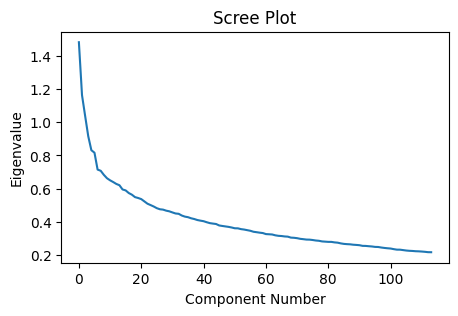

In [11]:
fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(pca_info['Singular Values'])
ax.set_title('Scree Plot')
ax.set_xlabel('Component Number')
ax.set_ylabel('Eigenvalue')
fig.show()

## Clustering Methods

For our use purposes, clustering securities based on their percent returns gives us an insight into which companies are affected by similar factors ie. which securites are likely to be cointegrated with one another. This is critical for reducing the computation time of our strategy, as rather than computing, for example, $\binom{500}{2} = 124,750$ cointegration tests for a universe of size $500$ stocks, if we can instead identify $20$ clusters, each with $25$ stocks, we reduce the number of cointegration tests nesseccary to $20 \times \binom{25}{2} = 3000$, which is roughly $2.4$%   of the brute forcee computation. Note that this can be optimized even further with algorithms that identify outliers. We will investigate three clustering algorithms - `K-Means`, `DBSCAN`, and `OPTICS`, to see which is most useful for this implementation.

### K-Means
K-Means clustering aims to partition data into $k$ clusters such that Euclidean distances within a cluster are minimized and distances between clusters are maximized. Traditionally, the elbow method is employed to determine the optimal number of $k$ clusters, where we determine the optimal number for $k$ based on the incremental reduction in distortion attained from further increasing k.


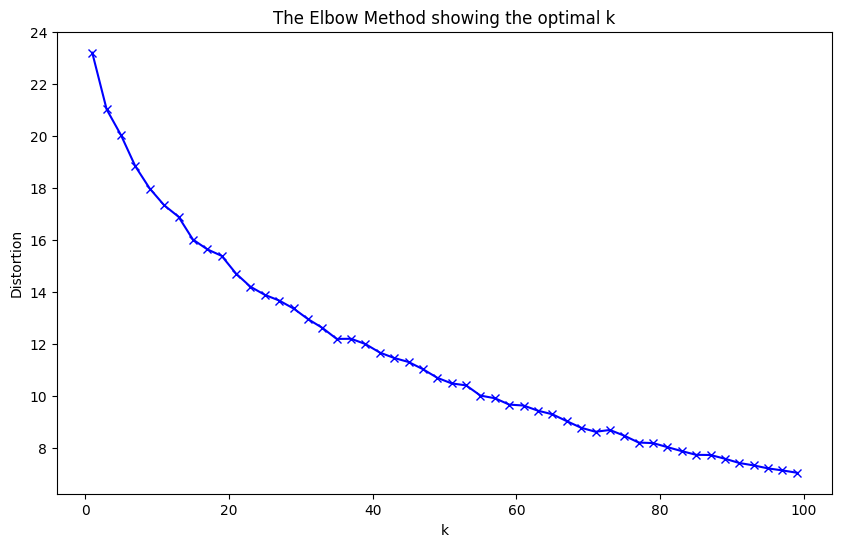

In [12]:
def find_optimal_k(transformed_data: np.ndarray):
    distortions = []
    K = range(1, 100, 2)
    for k in K:
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(transformed_data)
        distortions.append(kmeans.inertia_)
    plt.figure(figsize=(10,6))
    plt.plot(K, distortions, '-bx')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method showing the optimal k')
    plt.show()
find_optimal_k(transformed_data)

The K-Means algorithm is as follows:

Suppose we have $n$ input data points $x_1, \cdots, x_n$ and our predetermined value of `k = 11` industries.
1. Randomly select `k` of the $n$ data points, and let them be the `k` centroids of the `k` clusters. 
2. For each point in the data, determine the Euclidean distance from the point to the `k` centroids.
Note that the Euclidean Distance between two points $a, b \in \mathbb{R}^n$ is defined as the following: $$\text{distance}(\textbf{a}, \textbf{b}) = \sqrt{(a_1-b_1)^2 + \cdots + (a_n-b_n)^2}$$
3. Let each cluster centroid be denoted as $c_i \in C$ where $C$ is the set of all centroids, then each data point $x_i$ is assigned to the closest cluster defined by the above Euclidean distance, or $$\text{arg min}_{c_i\in C} \ \text{distance}(c_i, x)$$
4. Define the new centroid of the current cluster by taking the average of the points in the cluster. Let $S_i$ be the ith cluster. Then the new centroid is defined as $$c_i = \dfrac{1}{|S_i|}\sum_{x_i \in S_i} x_i$$ such that $S_i$ is the size of set $S_i$.
5. Continue to iterate through the input data points until the `k` centroids don't change. 

## Elbow Method vs. Industries
While the elbow method is widely used in research, we realized there were practical limitations when trying to determine when additional distortion is small enough to warrant selecting a value for $k$. Thus, we decided to instead use the number of industries $(11)$ as our $k$.

In [13]:
def kmeans_cluster(transformed_data: np.ndarray) -> List[int]:
    kmeans = KMeans(n_clusters = 35)
    labels = kmeans.fit_predict(transformed_data)
    # Number of clusters in labels, ignoring noise if present.
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = list(labels).count(-1)
    clusters = {}
    for i in range(len(labels)):
        if labels[i] != -1:
            clusters[labels[i]] = clusters.get(labels[i], "") + str(tickers[i]) + " "
    clusters = dict(sorted(clusters.items(), key=lambda x:x[0]))
    # Print some information about the clusters.
    print("Estimated number of clusters:", n_clusters)
    print("Estimated number of noise points:", n_noise)
    cluster_info = pd.DataFrame({'Cluster': clusters.keys(), 'Stocks': clusters.values()})
    cluster_info = cluster_info.set_index('Cluster')
    display(cluster_info.head(10))
    return labels

start_kmeans = time.perf_counter()
labels_kmeans = kmeans_cluster(transformed_data)

Estimated number of clusters: 35
Estimated number of noise points: 0


Stocks
Cluster                                                   
0        AAL BSX CNC COP CTRA DISH DUK ELV FDS FE GL HL...
1                                                     LLY 
2        MMM ABT ABBV ADP AAP AFL A APD ALB ARE ALGN AL...
3                                                     DIS 
4                                           JNPR LVS VRTX 
5                                                    BBWI 
6                                                     AZO 
7        AMGN CHTR CME CTSH DHR DG DOV EA FIS FTNT IR M...
8        AKAM ALK APA ANET CNP CF CMCSA CMI CVS XRAY DX...
9                                                     MTD

In [10]:
def find_cointegrated_pairs(df: pd.DataFrame, labels: List[int]):
    n = df.shape[1]
    keys = df.keys()
    # Define a dictionary that maps from pvalue to pair.
    pairsDict = {}
    for i in range(n):
        for j in range(i + 1, n):
            # Assert that both stocks are in the same cluster and not outliers.
            if labels[i] != -1 and labels[j] != -1 and labels[i] == labels[j]:
                S1 = close_data[keys[i]]        
                S2 = close_data[keys[j]]
                result = coint(S1, S2)
                pvalue = result[1]
                if pvalue < 0.05 and pvalue != 0:
                    pairsDict[(keys[i], keys[j])] = pvalue
    # Sort the pairs by lowest pvalue.
    keys, values = list(pairsDict.keys()), list(pairsDict.values())
    sorted_value_index = np.argsort(values)
    sorted_dict = {keys[i]: values[i] for i in sorted_value_index}
    return pd.DataFrame({'Pairs': sorted_dict.keys(), "PValues": sorted_dict.values()})

In [15]:
pairs_kmeans = find_cointegrated_pairs(close_data, labels_kmeans)
end_kmeans = time.perf_counter()
print(f"Time it takes KMEANS to generate pairs in a 500 stock universe size: {end_kmeans - start_kmeans}")
pairs_kmeans.head()

Time it takes KMEANS to generate pairs in a 500 stock universe size: 229.82695979997516


Pairs   PValues
0  (ATVI, STZ)  0.000003
1   (STE, VFC)  0.000011
2  (HON, PYPL)  0.000022
3  (HON, INTU)  0.000055
4    (HPE, KR)  0.000055

0                 1                                   2
0    HD  Home Depot (The)             Home Improvement Retail
1  VRSN          Verisign  Internet Services & Infrastructure

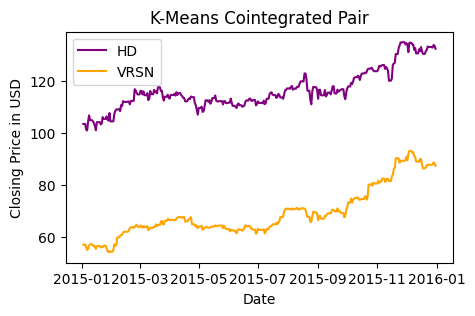

In [16]:
fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(close_data['HD'], label = 'HD', color='purple')
ax.plot(close_data['VRSN'], label = 'VRSN', color='orange')
ax.set_title('K-Means Cointegrated Pair')
ax.set_xlabel('Date')
ax.set_ylabel('Closing Price in USD')
ax.legend()
fig.show()

HD_VRSN = [(tickers[i], names[i], industries[i]) for i in range(len(tickers)) if tickers[i]=='HD' or tickers[i]=="VRSN"]
pd.DataFrame(HD_VRSN)

### DBSCAN (Density Based Spatial Clustering of Applications)

DBSCAN is a density-based clustering algorithm, which is best suited to deal with arbitrary shapes or outliers. Given that companies are unique entities, their returns will all be affected by factors differently, so we expect there to be many outliers. DBSCAN and OPTICS are very similar. Let us define parameters and subsequent definitions to algorithmically understand both methods.

1. `eps` ($\epsilon$): the distance that specifies neighbors



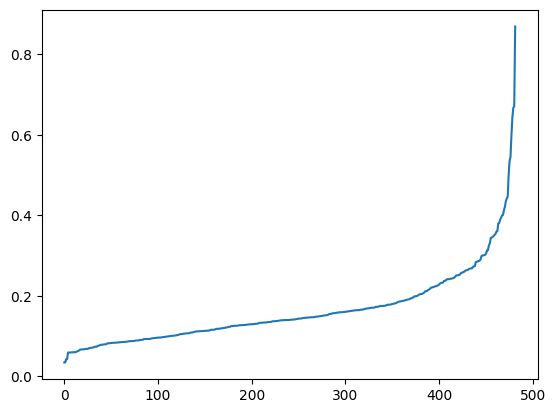

In [17]:
def find_optimal_eps(df: pd.DataFrame):
    nn = NearestNeighbors(n_neighbors=2)
    nbrs = nn.fit(df)
    distances, indices = nbrs.kneighbors(df)
    distances = np.sort(distances, axis=0)
    distances = distances[:,1]
    plt.plot(distances)

find_optimal_eps(transformed_data)

2. `minPts`: minimum number of data points to define a cluster. We will set this value to 2 because all we need is 2 stocks in a cluster to potentially have a cointegrated and therefore highly profitable pair.

These two parameters allow us to define the following 3 definitions.

1. **core point:** a point `x` such that there at least `minPts` number of points (inclusive of the point itself) in the closed ball $B_\epsilon(x)$.
2. **border point:** a point `x` such that it is reachable from a core point and there are less than `minPts` number of points within $B_\epsilon(x)$.
3. **outlier:** a point such that it is not a core point and it is not reachable from any core points.

The DBSCAN algorithm is as follows:

1. `minPts` and `eps` are predetermined. Suppose there exist $n$ data points $x_1, \cdots, x_n \in X$. Select a starting point $x_i$ at random.
2. Let $S$ be the set of all points in $B_\epsilon (x_i)$. If $|S| >= \ $ `minPts`, then $x_i$ is marked as a core point and cluster formation starts. Otherwise, the point is marked as noise. All other points $x_j \in B_{\epsilon}(x_i)$ become a part of the cluster. 
3. If for the other $x_j$, if there exists at least `minPts` in $B_\epsilon(x_j)$, then $x_j$ is also determined to be core points, then all $x_k \in B_\epsilon(x_j)$ are also added to the cluster and evaluated if they are core points.
4. Once that cluster is formed, choose another random point that has not been visited yet and follow the same procedure. Note that points that are marked as noise can be revisited.
5. The algorithm is done when all points classified as part of a cluster or a noise point.

In [18]:
def dbscan_cluster(transformed_data: np.ndarray) -> List[int]: 
    db = DBSCAN(eps = 0.1, min_samples = 2)
    labels = db.fit_predict(transformed_data)
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = list(labels).count(-1)
    clusters = {}
    for i in range(len(labels)):
        if labels[i] != -1:
            clusters[labels[i]] = clusters.get(labels[i], "") + str(tickers[i]) + " "
    clusters = dict(sorted(clusters.items(), key=lambda x:x[0]))
    # Print out some information about the clusters.
    print("Estimated number of clusters:", n_clusters)
    print("Estimated number of noise points:", n_noise)
    cluster_info = pd.DataFrame({'Cluster': clusters.keys(), 'Stocks': clusters.values()})
    cluster_info = cluster_info.set_index('Cluster')
    display(cluster_info.head())
    return labels

start_dbscan = time.perf_counter()
labels_dbscan = dbscan_cluster(transformed_data)

Estimated number of clusters: 11
Estimated number of noise points: 370


Stocks
Cluster                                                   
0        ADBE ARE LNT AXP ABC ATO BALL BDX BRK.B TECH B...
1                                           A EQT HST NEE 
2        AKAM ALK APA ANET CNP CMCSA CMI CVS XRAY DXCM ...
3        AON AMAT BA CHD DPZ DTE EIX EL ITW KEYS MOS OX...
4                                        CBOE IBM PSX WMT

In [19]:
pairs_dbscan = find_cointegrated_pairs(close_data, labels_dbscan)
end_dbscan = time.perf_counter()
print(f"Time it takes DBSCAN to generate pairs in a 500 stock universe size: {end_dbscan - start_dbscan}")
pairs_dbscan.head()

Time it takes DBSCAN to generate pairs in a 500 stock universe size: 20.760144600004423


Pairs   PValues
0  (HON, RJF)  0.000002
1  (HON, WFC)  0.000064
2   (AEP, SO)  0.000103
3  (HON, LNC)  0.000114
4   (ES, PCG)  0.000236

0              1                               2
0  HON      Honeywell        Industrial Conglomerates
1  RJF  Raymond James  Investment Banking & Brokerage

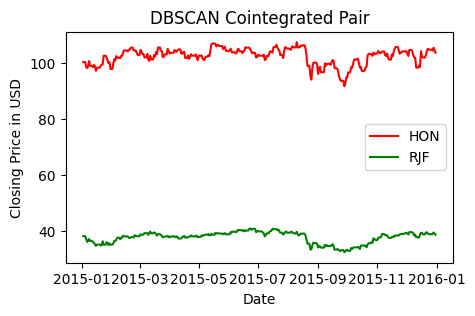

In [20]:
fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(close_data['HON'], label = 'HON', color='red')
ax.plot(close_data['RJF'], label = 'RJF', color='green')
ax.set_title('DBSCAN Cointegrated Pair')
ax.set_xlabel('Date')
ax.set_ylabel('Closing Price in USD')
ax.legend()
fig.show()

hon_rjf = [(tickers[i], names[i], industries[i]) for i in range(len(tickers)) if tickers[i]=='HON' or tickers[i]=="RJF"]
pd.DataFrame(hon_rjf)

### OPTICS (Ordering Points to Identify Cluster Structure)

We observe firsthand that the Elbow Technique to determine optimal `eps` is unreliable and cumbersome. Such a small difference in the value of `eps` can drastically transform final results. This required level of precision for `eps` limits DBSCAN predominantly to the detection of clusters of similar density. OPTICS solves this issue 

In [21]:
def optics_cluster(transformed_data: np.ndarray) -> List[int]:
    optics = OPTICS(min_samples = 2)
    labels = optics.fit_predict(transformed_data)
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = list(labels).count(-1)
    # Obtain info about the clusters.
    clusters = {}
    for i in range(len(labels)):
        if labels[i] != -1:
            clusters[labels[i]] = clusters.get(labels[i], "") + str(tickers[i]) + " "
    clusters = dict(sorted(clusters.items(), key=lambda x:x[0]))
    # Print out some infomration about the clusters.
    print("Estimated number of clusters:", n_clusters)
    print("Estimated number of noise points:", n_noise)
    cluster_info = pd.DataFrame({'Cluster': clusters.keys(), 'Stocks': clusters.values()})
    cluster_info = cluster_info.set_index('Cluster')
    display(cluster_info.head())
    return labels
    
start_optics = time.perf_counter()
labels_optics = optics_cluster(transformed_data)

Estimated number of clusters: 40
Estimated number of noise points: 375


Stocks
Cluster                                
0                         ABC TECH LYV 
1                              BMY STT 
2                             LNT BIIB 
3                              ARE EXR 
4        BKNG FLT HUM OMC SBNY TER UAL

In [22]:
pairs_optics = find_cointegrated_pairs(close_data, labels_optics)
end_optics = time.perf_counter()
print(f"Time it takes OPTICS to generate pairs in a 500 stock universe size: {end_optics - start_optics}")
pairs_optics.head()

Time it takes OPTICS to generate pairs in a 500 stock universe size: 5.964553400001023


Pairs   PValues
0   (AEE, XEL)  0.000607
1   (AEE, CMS)  0.000917
2   (PNW, WEC)  0.006713
3   (TFC, WFC)  0.010048
4  (ICE, NDAQ)  0.013386

0            1                2
0  AEE       Ameren  Multi-Utilities
1  XEL  Xcel Energy  Multi-Utilities

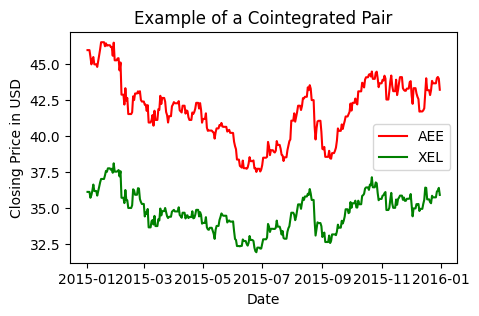

In [23]:
fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(close_data['AEE'], label = 'AEE', color='red')
ax.plot(close_data['XEL'], label = 'XEL', color='green')
ax.set_title('Example of a Cointegrated Pair')
ax.set_xlabel('Date')
ax.set_ylabel('Closing Price in USD')
ax.legend()
fig.show()

aee_xel = [(tickers[i], names[i], industries[i]) for i in range(len(tickers)) if tickers[i]=='AEE' or tickers[i]=="XEL"]
pd.DataFrame(aee_xel)

## Testing KMeans vs. DBSCAN vs. OPTICS in Alphas

OPTICS: 100%|████████████████████████████████████████████████████████████████████████| 3/3 [2:51:42<00:00, 3434.18s/it]


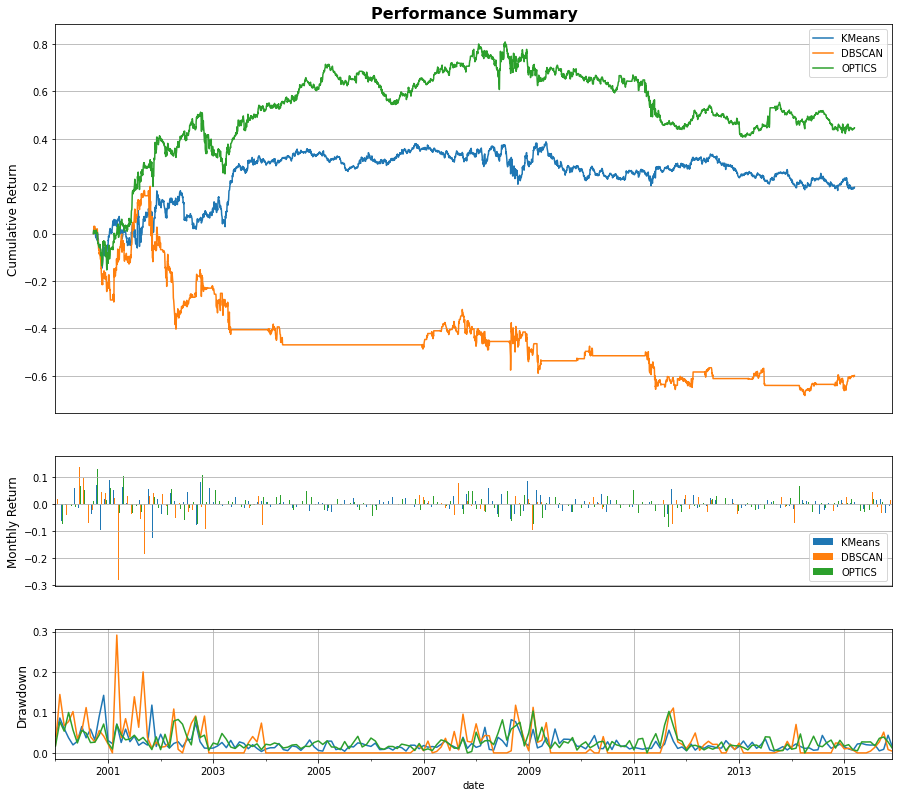

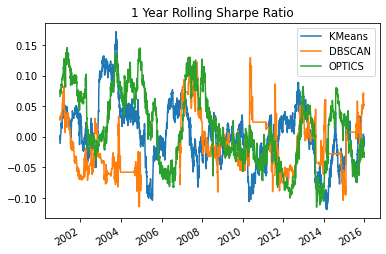

KMeans


return    sharpe   sortino  drawdown  turnover  long count  \
year                                                                    
2000    -0.034531 -0.156207 -0.275616  0.154829  0.178865    7.722222   
2001     0.107809  0.572918  0.860101  0.121188  0.178751    7.133065   
2002     0.205780  1.622577  2.994472  0.119937  0.209870    7.174603   
2003     0.038693  0.508940  0.747256  0.041503  0.186649    7.734127   
2004    -0.004853 -0.088510 -0.132283  0.055947  0.137782    8.146825   
2005    -0.011859 -0.219900 -0.348611  0.062627  0.153229    7.404762   
2006     0.052250  0.855936  1.228293  0.031901  0.203342    7.641434   
2007    -0.013907 -0.207839 -0.346033  0.070556  0.173673    7.932271   
2008    -0.098696 -0.612760 -0.896314  0.160237  0.181329    8.043478   
2009     0.041718  0.374829  0.624914  0.132865  0.178938    7.575397   
2010    -0.039206 -0.628343 -0.960726  0.060874  0.173470    7.626984   
2011     0.024971  0.295778  0.391893  0.067499  0.190962    7.579365   
2012     0.058829  1.000100  1.630095  0.030381  0.186828    7.416000   
2013    -0.077712 -1.461734 -1.945472  0.096530  0.161242    8.218254   
2014    -0.053318 -0.923747 -1.303386  0.082125  0.194172    8.111111   
2015    -0.000728 -0.011242 -0.015968  0.070297  0.176170    7.265873   
Overall  0.195239  0.113800  0.161969  0.196607  0.246842    7.671056   

         short count  
year                  
2000        6.722222  
2001        6.133065  
2002        6.174603  
2003        6.734127  
2004        7.146825  
2005        6.404762  
2006        6.641434  
2007        6.932271  
2008        7.043478  
2009        6.575397  
2010        6.626984  
2011        6.579365  
2012        6.416000  
2013        7.218254  
2014        7.111111  
2015        6.265873  
Overall     6.671056


DBSCAN


return    sharpe   sortino  drawdown  turnover  long count  \
year                                                                    
2000     0.117513  0.438461  0.739601  0.279975  0.167133    4.468254   
2001    -0.413593 -1.041556 -1.120192  0.486665  0.129075    3.072581   
2002    -0.109759 -0.489983 -0.649049  0.254816  0.047414    1.674603   
2003    -0.063867 -0.916326 -1.175804  0.085575  0.008511    1.289683   
2004     0.000000       NaN       NaN  0.000000  0.000000    1.000000   
2005     0.000000       NaN       NaN  0.000000  0.000000    1.000000   
2006     0.022858  0.725236  1.242432  0.019174  0.004237    1.059761   
2007     0.044708  0.401914  0.638449  0.100492  0.133903    2.195219   
2008    -0.030672 -0.124533 -0.199367  0.166226  0.052575    2.193676   
2009    -0.104123 -0.748043 -0.950105  0.167191  0.030043    1.464286   
2010     0.021371  0.384089  0.540455  0.040384  0.017021    1.142857   
2011    -0.121096 -1.118525 -1.276182  0.151177  0.059072    1.750000   
2012     0.062264  0.716902  1.134576  0.053914  0.069328    1.612000   
2013    -0.027157 -0.596647 -0.735792  0.028553  0.025751    1.242063   
2014    -0.056727 -0.944436 -1.007197  0.109587  0.045448    2.297619   
2015     0.059286  0.835984  1.137173  0.066133  0.086948    3.349206   
Overall -0.598994 -0.232847 -0.303385  0.645691  0.086082    1.924969   

         short count  
year                  
2000        3.468254  
2001        2.072581  
2002        0.674603  
2003        0.289683  
2004        0.000000  
2005        0.000000  
2006        0.059761  
2007        1.195219  
2008        1.193676  
2009        0.464286  
2010        0.142857  
2011        0.750000  
2012        0.612000  
2013        0.242063  
2014        1.297619  
2015        2.349206  
Overall     0.924969


OPTICS


return    sharpe   sortino  drawdown  turnover  long count  \
year                                                                    
2000     0.218474  1.054676  1.717607  0.159915  0.223120    6.801587   
2001     0.195758  1.038189  1.680202  0.109630  0.182860    6.963710   
2002     0.006488  0.032886  0.047153  0.240488  0.150082    4.936508   
2003     0.129430  1.192581  1.741977  0.060810  0.199073    4.309524   
2004     0.144092  1.854379  3.180775  0.053674  0.181805    5.003968   
2005    -0.062919 -0.792113 -1.103850  0.079965  0.168584    3.579365   
2006    -0.001719 -0.021737 -0.027877  0.079167  0.185961    5.685259   
2007     0.147951  2.019832  3.152348  0.042394  0.152864    3.513944   
2008    -0.027665 -0.135011 -0.235130  0.178387  0.135684    5.430830   
2009    -0.063445 -0.472572 -0.608192  0.145997  0.181801    5.797619   
2010    -0.071755 -0.960432 -1.474929  0.099038  0.181682    5.392857   
2011    -0.157948 -1.056810 -1.302375  0.199840  0.102120    2.801587   
2012     0.066990  1.132081  1.779708  0.038399  0.198095    6.312000   
2013    -0.088731 -1.492119 -1.800473  0.103789  0.149484    7.265873   
2014     0.048420  0.541784  0.773401  0.106502  0.121356    4.527778   
2015    -0.037248 -0.529738 -0.734052  0.093387  0.177352    6.742063   
Overall  0.446172  0.217995  0.300953  0.353803  0.235754    5.314783   

         short count  
year                  
2000        5.801587  
2001        5.963710  
2002        3.936508  
2003        3.309524  
2004        4.003968  
2005        2.579365  
2006        4.685259  
2007        2.513944  
2008        4.430830  
2009        4.797619  
2010        4.392857  
2011        1.801587  
2012        5.312000  
2013        6.265873  
2014        3.527778  
2015        5.742063  
Overall     4.314783

In [8]:
from sif.pairstrading.alphas import KMeans_Alpha, DBSCAN_Alpha, OPTICS_Alpha
alphas = [KMeans_Alpha(90, 10, 0.5), DBSCAN_Alpha(90, 10, 0.5), OPTICS_Alpha(90, 10, 0.5)]
returns, holdings = backtester_15y.backtest(alphas, processes=None)
metrics.summary_plot(returns, source=['KMeans', 'DBSCAN', 'OPTICS'])
rolling_sharpe = functools.partial(metrics.rolling_metric, func=metrics.sharpe_ratio, window=252)
returns.apply(rolling_sharpe).plot()
plt.title('1 Year Rolling Sharpe Ratio')
plt.show()
# Display analytics.
perf_tables = apply_metric_func(metrics.generate_performance_table, ('daily_returns', 'holdings'))(returns, holdings)
for alpha, table in zip(alphas, perf_tables):
    print(f"{alpha.name}")
    ICD.display(table)
    print()

## Clustering Conclusion

Of the three methods, we select OPTICS to use in our final alpha moving forward. Although the OPTICS and K-Means clustering methods give similar performance, OPTICS runs much quicker, and K-Means is further limited by the need to manually select $k$. 

Thus, we will continue to build on our alpha using OPTICS as our clustering method for the rest of the notebook.

**Critically, notice that the performance of these alphas is similar/better than the original brute force lowest pvalue alpha. This is extremely important as it means we are losing minimal value by using clustering to reduce the number of pairs of securities we check cointegration between, while gaining massive computational advantage.**

## Time Complexity Analysis - Clustering vs. Original

The objective of principal component analysis and clustering methods is to identify cointegrated pairs faster and more efficiently. To test the success of this new implementation, we conduct a time complexity analysis of a bare bones pairs trading strategy versus an enhanced strategy when both are tested in a $500$ stock universe. 

To accomplish this, We create a shorter $6$ month backtester, as running the original pairs trading alpha on a $500$ stock universe is very slow.

In [25]:
# *** FOP TIME COMPLEXITY ANALYSIS *** #
start_date_6m = datetime.datetime(2005, 1, 1)
end_date_6m = datetime.datetime(2005, 6, 30)
# backtester_6m = fb.FullMultipleBacktester(
#     start_date_6m,
#     end_date_6m,
#     'M',
#     273,
#     universe_size = 500, 
#     factors=['close', 'sector']
# )
# backtester_6m.save_local('pairs_6m.npy')
backtester_6m = fb.FullMultipleBacktester.from_local('pairs_6m.npy')

In [35]:
from sif.pairstrading.alphas import Brute_Force, Testing2

# Run the brute force alpha and time it.
alphas = [Brute_Force(90, 10, 3.5)]
start_random = time.perf_counter()
returns, holdings = backtester_6m.backtest(alphas, processes=None)
end_random = time.perf_counter()

# run the enhanced alpha and time it
alphas = [Testing2(90, 10, 2.25, 1.75, 3.5)]
start_final = time.perf_counter()
returns2, holdings2 = backtester_6m.backtest(alphas, processes=None)
end_final = time.perf_counter()

print(f"Time for the Random Alpha: {end_random - start_random} seconds")
print(f"Time for the Enhanced Alpha: {end_final - start_final} seconds")

Testing2: 100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.94s/it]

Time for the Random Alpha: 2433.187252399999 seconds
Time for the Enhanced Alpha: 6.951922000000195 seconds


In [ ]:
# run the brute force alpha and time it
alphas = [Brute_Force(90, 10, 3.5)]
start_random = time.perf_counter()
returns, holdings = backtester_6m.backtest(alphas, processes=None)
end_random = time.perf_counter()

In [27]:
# run the enhanced alpha and time it
alphas = [Testing2(90, 10, 2.25, 1.75, 3.5)]
start_final = time.perf_counter()
returns2, holdings2 = backtester_6m.backtest(alphas, processes=None)
end_final = time.perf_counter()

print(f"Time for the Random Alpha: {end_random - start_random} seconds")
print(f"Time for the Enhanced Alpha: {end_final - start_final} seconds")

Testing2: 100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.51s/it]

Time for the Random Alpha: 2495.6983089000023 seconds
Time for the Enhanced Alpha: 6.517251000001124 seconds


## Time Complexity Results

As we can see, the pairs trading alpha with clustering runs over $350$ times faster than the original alpha, even though it gives similar performance. We ran the comparison a second time to ensure the results were accurate, as it was already surprising to see such a large performance change.

We consider this implementation successful at reducing our computational speeds to allow us to adequately test and use pairs trading alphas with larger universes.

# Pairs Trading Parameters

There are many parameters that we can tune for pairs trading to build the optimal strategy. In this portion of the notebook, we will explore them.

### Thresholds

We define opening and closing of trade thresholds for our trades by cutoff values of the z-score of the spread between the price timeseries of the two securities. Z-score is defined as $$z = \dfrac{x-\mu}{\sigma}$$ where $x$ is some value, $\mu$ is the mean, and $\sigma$ is the standard deviation, and this value represents the number of standard deviations away from the mean our current value is.

In [6]:
def zscore(series: array_1d) -> array_1d:
    return (series - series.mean()) / np.std(series)

In [26]:
pairsDict = dict(np.array(pairs_optics))
pairsDict
# Sort the pairs by lowest pvalue.
keys, values = list(pairsDict.keys()), list(pairsDict.values())
sorted_value_index = np.argsort(values)
sorted_dict = {keys[i]: values[i] for i in sorted_value_index}

# Remove duplicate stocks.
new_dict, seen = {}, set()
for (i, j) in sorted_dict:
    if i not in seen and j not in seen:
        new_dict[(i, j)] = sorted_dict[(i,j)]
        seen.add(i)
new_dict

{('AEE', 'XEL'): 0.0006074891966837364,
 ('PNW', 'WEC'): 0.006712663328868038,
 ('TFC', 'WFC'): 0.010048276260052667,
 ('ICE', 'NDAQ'): 0.01338565196103155,
 ('AMT', 'CCI'): 0.01917978540057863,
 ('KO', 'PEP'): 0.027679852301702584,
 ('CMS', 'ES'): 0.03140211257431001,
 ('AON', 'MMC'): 0.03678558565664893,
 ('C', 'HBAN'): 0.037287845225351904,
 ('CI', 'UNH'): 0.04340813007876985}

### Open Position Criteria

A trade will be initialized (ie. we take a long position for the underperforming security and a short position on the overperforming security) when the absolute value of the zscore of the spread is greater than our open threshold, currently $1.0$.
### Close Position Criteria

The trade will be closed when the asbolute value of the zscore of the spread becomes less than our close (take profit) threshold, which is currently $0.5$. If this threshold is reached on an open position, it means the difference between close prices have revered back toward their mean and a profit should be made.

### Stop Loss Criteria

In the circumstance where two securities seem to continue to diverge beyond what we consider reasonable, we propose a mechanism for cutting our losses by exiting the trade. If the absolute of the zscore of the spread ever becomes greater than our stop loss threshold, we reevaluate the cointegration levels again using the Engle-Granger test. If the resulting pvalue is greater than $0.05$ (no longer cointegrated), we choose to suspect that the pair is no longer cointegrated, and we will exit the trade and take our losses before the securities further diverge and result in even greater losses.

In [16]:
WINDOW, OPEN, CLOSE = 90, 2.1, 1.9
# WINDOW = 90
# OPEN = 1.0
# CLOSE = 0.5
factors = ['Zscore', 'Close Prices', 'Spread']
df = {factor : pd.DataFrame(np.zeros((180-WINDOW, len(new_dict)))) for factor in factors}
pairs = [pair for pair in new_dict]

for factor in df:
    df[factor] = df[factor].rename_axis("Day")
    df[factor] = df[factor].set_axis(pairs, axis="columns")
    new_axis = [i for i in range(WINDOW, 180)]
    df[factor] = df[factor].set_axis(new_axis, axis="rows")
    df[factor] = df[factor].rename_axis(f"{factor} of Pairs", axis="columns")
    display(df[factor].head())

Zscore of Pairs  (AEP, SO)  (ES, PCG)  (AEE, XEL)  (PCG, SO)  (PNW, WEC)  \
90                     0.0        0.0         0.0        0.0         0.0   
91                     0.0        0.0         0.0        0.0         0.0   
92                     0.0        0.0         0.0        0.0         0.0   
93                     0.0        0.0         0.0        0.0         0.0   
94                     0.0        0.0         0.0        0.0         0.0   
..                     ...        ...         ...        ...         ...   
175                    0.0        0.0         0.0        0.0         0.0   
176                    0.0        0.0         0.0        0.0         0.0   
177                    0.0        0.0         0.0        0.0         0.0   
178                    0.0        0.0         0.0        0.0         0.0   
179                    0.0        0.0         0.0        0.0         0.0   

Zscore of Pairs  (TFC, WFC)  (ICE, NDAQ)  (AMT, CCI)  (CNP, DUK)  (KO, PEP)  \
90                      0.0          0.0         0.0         0.0        0.0   
91                      0.0          0.0         0.0         0.0        0.0   
92                      0.0          0.0         0.0         0.0        0.0   
93                      0.0          0.0         0.0         0.0        0.0   
94                      0.0          0.0         0.0         0.0        0.0   
..                      ...          ...         ...         ...        ...   
175                     0.0          0.0         0.0         0.0        0.0   
176                     0.0          0.0         0.0         0.0        0.0   
177                     0.0          0.0         0.0         0.0        0.0   
178                     0.0          0.0         0.0         0.0        0.0   
179                     0.0          0.0         0.0         0.0        0.0   

Zscore of Pairs  (ETR, FE)  (AON, MMC)  (C, HBAN)  (DUK, FE)  (CI, UNH)  \
90                     0.0         0.0        0.0        0.0        0.0   
91                     0.0         0.0        0.0        0.0        0.0   
92                     0.0         0.0        0.0        0.0        0.0   
93                     0.0         0.0        0.0        0.0        0.0   
94                     0.0         0.0        0.0        0.0        0.0   
..                     ...         ...        ...        ...        ...   
175                    0.0         0.0        0.0        0.0        0.0   
176                    0.0         0.0        0.0        0.0        0.0   
177                    0.0         0.0        0.0        0.0        0.0   
178                    0.0         0.0        0.0        0.0        0.0   
179                    0.0         0.0        0.0        0.0        0.0   

Zscore of Pairs  (CMS, WEC)  
90                      0.0  
91                      0.0  
92                      0.0  
93                      0.0  
94                      0.0  
..                      ...  
175                     0.0  
176                     0.0  
177                     0.0  
178                     0.0  
179                     0.0  

[90 rows x 16 columns]

Close Prices of Pairs  (AEP, SO)  (ES, PCG)  (AEE, XEL)  (PCG, SO)  \
90                           0.0        0.0         0.0        0.0   
91                           0.0        0.0         0.0        0.0   
92                           0.0        0.0         0.0        0.0   
93                           0.0        0.0         0.0        0.0   
94                           0.0        0.0         0.0        0.0   
..                           ...        ...         ...        ...   
175                          0.0        0.0         0.0        0.0   
176                          0.0        0.0         0.0        0.0   
177                          0.0        0.0         0.0        0.0   
178                          0.0        0.0         0.0        0.0   
179                          0.0        0.0         0.0        0.0   

Close Prices of Pairs  (PNW, WEC)  (TFC, WFC)  (ICE, NDAQ)  (AMT, CCI)  \
90                            0.0         0.0          0.0         0.0   
91                            0.0         0.0          0.0         0.0   
92                            0.0         0.0          0.0         0.0   
93                            0.0         0.0          0.0         0.0   
94                            0.0         0.0          0.0         0.0   
..                            ...         ...          ...         ...   
175                           0.0         0.0          0.0         0.0   
176                           0.0         0.0          0.0         0.0   
177                           0.0         0.0          0.0         0.0   
178                           0.0         0.0          0.0         0.0   
179                           0.0         0.0          0.0         0.0   

Close Prices of Pairs  (CNP, DUK)  (KO, PEP)  (ETR, FE)  (AON, MMC)  \
90                            0.0        0.0        0.0         0.0   
91                            0.0        0.0        0.0         0.0   
92                            0.0        0.0        0.0         0.0   
93                            0.0        0.0        0.0         0.0   
94                            0.0        0.0        0.0         0.0   
..                            ...        ...        ...         ...   
175                           0.0        0.0        0.0         0.0   
176                           0.0        0.0        0.0         0.0   
177                           0.0        0.0        0.0         0.0   
178                           0.0        0.0        0.0         0.0   
179                           0.0        0.0        0.0         0.0   

Close Prices of Pairs  (C, HBAN)  (DUK, FE)  (CI, UNH)  (CMS, WEC)  
90                           0.0        0.0        0.0         0.0  
91                           0.0        0.0        0.0         0.0  
92                           0.0        0.0        0.0         0.0  
93                           0.0        0.0        0.0         0.0  
94                           0.0        0.0        0.0         0.0  
..                           ...        ...        ...         ...  
175                          0.0        0.0        0.0         0.0  
176                          0.0        0.0        0.0         0.0  
177                          0.0        0.0        0.0         0.0  
178                          0.0        0.0        0.0         0.0  
179                          0.0        0.0        0.0         0.0  

[90 rows x 16 columns]

Spread of Pairs  (AEP, SO)  (ES, PCG)  (AEE, XEL)  (PCG, SO)  (PNW, WEC)  \
90                     0.0        0.0         0.0        0.0         0.0   
91                     0.0        0.0         0.0        0.0         0.0   
92                     0.0        0.0         0.0        0.0         0.0   
93                     0.0        0.0         0.0        0.0         0.0   
94                     0.0        0.0         0.0        0.0         0.0   
..                     ...        ...         ...        ...         ...   
175                    0.0        0.0         0.0        0.0         0.0   
176                    0.0        0.0         0.0        0.0         0.0   
177                    0.0        0.0         0.0        0.0         0.0   
178                    0.0        0.0         0.0        0.0         0.0   
179                    0.0        0.0         0.0        0.0         0.0   

Spread of Pairs  (TFC, WFC)  (ICE, NDAQ)  (AMT, CCI)  (CNP, DUK)  (KO, PEP)  \
90                      0.0          0.0         0.0         0.0        0.0   
91                      0.0          0.0         0.0         0.0        0.0   
92                      0.0          0.0         0.0         0.0        0.0   
93                      0.0          0.0         0.0         0.0        0.0   
94                      0.0          0.0         0.0         0.0        0.0   
..                      ...          ...         ...         ...        ...   
175                     0.0          0.0         0.0         0.0        0.0   
176                     0.0          0.0         0.0         0.0        0.0   
177                     0.0          0.0         0.0         0.0        0.0   
178                     0.0          0.0         0.0         0.0        0.0   
179                     0.0          0.0         0.0         0.0        0.0   

Spread of Pairs  (ETR, FE)  (AON, MMC)  (C, HBAN)  (DUK, FE)  (CI, UNH)  \
90                     0.0         0.0        0.0        0.0        0.0   
91                     0.0         0.0        0.0        0.0        0.0   
92                     0.0         0.0        0.0        0.0        0.0   
93                     0.0         0.0        0.0        0.0        0.0   
94                     0.0         0.0        0.0        0.0        0.0   
..                     ...         ...        ...        ...        ...   
175                    0.0         0.0        0.0        0.0        0.0   
176                    0.0         0.0        0.0        0.0        0.0   
177                    0.0         0.0        0.0        0.0        0.0   
178                    0.0         0.0        0.0        0.0        0.0   
179                    0.0         0.0        0.0        0.0        0.0   

Spread of Pairs  (CMS, WEC)  
90                      0.0  
91                      0.0  
92                      0.0  
93                      0.0  
94                      0.0  
..                      ...  
175                     0.0  
176                     0.0  
177                     0.0  
178                     0.0  
179                     0.0  

[90 rows x 16 columns]

In [28]:
# We need to wait the first 1/4 s.t. we can calculate zscore.
for day in range(WINDOW, 180):
    for p in new_dict:
        # Obtain the two time series.
        FIRST = (close_data[p[0]]).iloc[day-WINDOW:day]
        SECOND = (close_data[p[1]]).iloc[day-WINDOW:day]
        # Determine the values for our factors.
        close_price = f"({round(close_data[p[0]][day], 2)} , {round(close_data[p[1]][day], 2)})"
        spread = FIRST - SECOND
        z_score = zscore(spread).tail(1).values[0]
        diff = close_data[p[0]][day] - close_data[p[1]][day]
        # Add these values to dataframes for future examination.
        for factor in factors:
            if factor == "Zscore":
                if z_score >= OPEN:
                    # Update current trade status.
                    df[factor][p][day] = f"OPEN {round(z_score, 2)}"

                # Exit the trade; dont increment anything.
                elif abs(z_score) <= CLOSE:
                    df[factor][p][day] = f"CLOSED {round(z_score, 2)}"

                elif z_score <= -OPEN:
                    # Update the current trade status here too.
                    df[factor][p][day] = f"OPEN {round(z_score, 2)}"
            # Record close prices and spreads.
            elif factor == "Close Prices":
                df[factor][p][day] = close_price
            elif factor == "Spread":
                df[factor][p][day] = round(diff, 2)

In [ ]:
for factor in factors:
    print(df[factor].to_markdown())

See the `eda_traced.py` file for the results. Now we will illustrate the trade status in a visual graph.

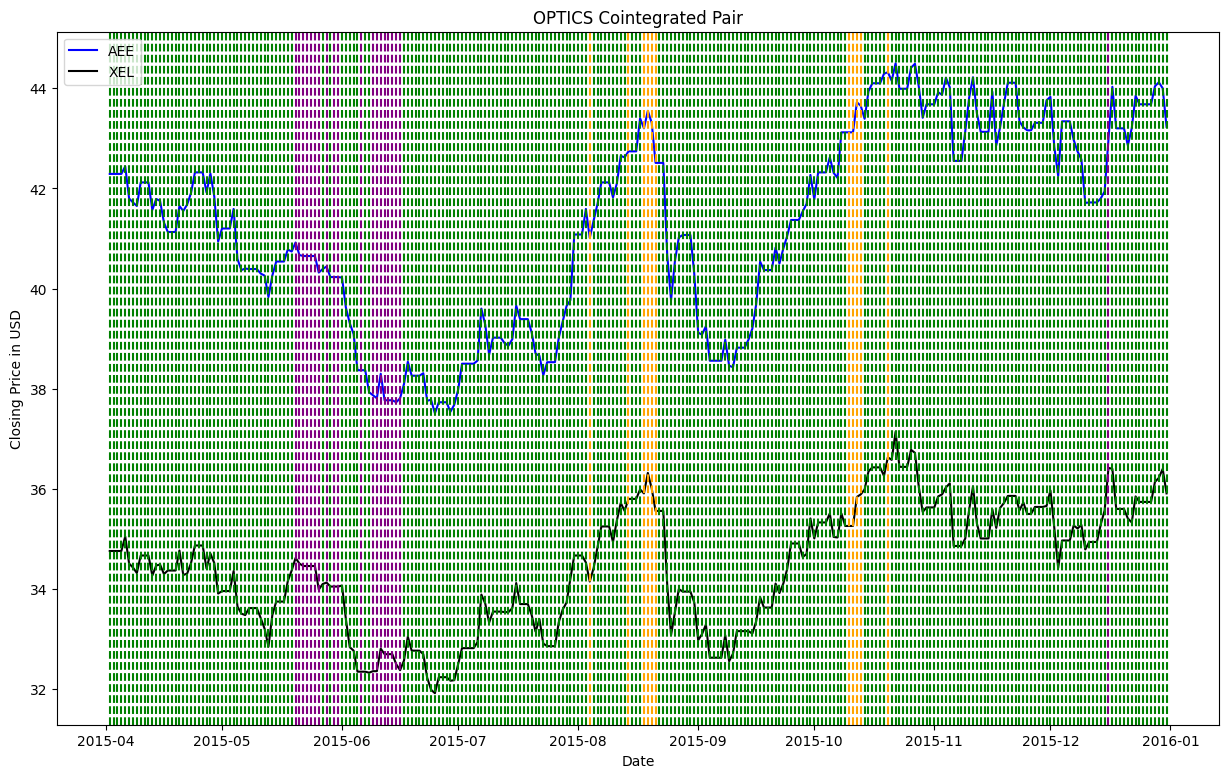

In [30]:
# Isolate the two time series.
aee = pd.DataFrame(close_data["AEE"])
xel = pd.DataFrame(close_data["XEL"])
aee_2 = aee[WINDOW:]
xel_2 = xel[WINDOW:]
# Plot the two stocks.
fig, ax = plt.subplots(figsize=(15, 9))
ax.plot(aee_2, label = 'AEE', color='blue')
ax.plot(xel_2, label = 'XEL', color='black')
# Plot the trade status for this cointegrated pair.
for day in range(WINDOW, len(aee)):
    aee_2 = aee.iloc[day-WINDOW:day]
    xel_2 = xel.iloc[day-WINDOW:day]
    spread = aee_2['AEE'] - xel_2['XEL']
    z_score = zscore(spread).tail(1).values[0]
    # Plot a different vertical line color depending on the status.
    if z_score > OPEN:
        plt.axvline(x=(aee.reset_index())['date'][day], color='orange', linestyle='--')
    elif abs(z_score) < CLOSE:
        plt.axvline(x=(aee.reset_index())['date'][day], color='green', linestyle='--')
    elif z_score < -OPEN:
        plt.axvline(x=(aee.reset_index())['date'][day], color='purple', linestyle='--')

ax.set_title('OPTICS Cointegrated Pair')
ax.set_xlabel('Date')
ax.set_ylabel('Closing Price in USD')
ax.legend()
fig.show()

## Information about the OPTICS Pairs
- Number of pairs trades opened.
- Average length of trade opened.
- Generate a graph of the zscore distributions.

In [31]:
# *** NUMBER OF PAIR TRADES OPENED *** #
# A dictionary that maps from a pair to a boolean indicating if the pair is active.
pair_to_status = {pair : [0, False] for pair in new_dict}

# *** AVERAGE CHANGE IN ZSCORE FOR EACH PAIR *** #
# A dictionary that maps from a pair to changes in zscore. THe first index 
# represents postiive shifts, second is negative shifts, third is overall.
pair_to_delta_zscore = {pair : [0, 0, 0] for pair in new_dict}
pos, neg = 0, 0

# *** MAX, MIN CHANGE IN ZSCORE FOR EACH PAIR *** #
# dict that maps from a pair to changes in zscore
# first index represents postiive shifts, second is negative shifts, third is overall
pair_to_minmax_zscore = {pair : [0, 0] for pair in new_dict}

# *** NUMBER OF PAIR TRADES CLOSED *** #
# A dictionary that maps from a pair to a boolean indicating if the pair is closed.
pair_to_close = {pair : 0 for pair in new_dict}

# *** TOTAL LENGTH OF EACH TRADE OPENED *** #
# A dictionary that maps from pair to total time opened. To get average, 
# we will divide by number of trades after.
pair_to_total_time = {pair : 0 for pair in new_dict}

# *** AVERAGE LENGTH OF EACH TRADE OPENED *** #
# To get average, will divide by number of trades after.
pair_to_average_time = {pair : 0 for pair in new_dict}

# *** ZSCORE FREQUENCY *** #
# A dictionary that maps from a zscore to the number of occurrences
zscore_freq = {}

In [32]:
# We need to wait the first 1/4 s.t. we can calculate zscore.
for day in range(WINDOW, len(close_data)):
    for p in new_dict:
        # FIRST and SECOND are indices of the stocks.
        FIRST = (close_data[p[0]]).iloc[day-WINDOW:day]
        SECOND = (close_data[p[1]]).iloc[day-WINDOW:day]
        spread = FIRST - SECOND
        # Calculate zscore.
        z_score = zscore(spread).tail(1).values[0]
        if z_score > 0:
            pair_to_delta_zscore[p][0] += z_score
            pos += 1
            pair_to_minmax_zscore[p][0] = max(z_score, pair_to_minmax_zscore[p][0])
        else:
            pair_to_delta_zscore[p][1] += z_score
            neg += 1
            pair_to_minmax_zscore[p][1] = min(z_score, pair_to_minmax_zscore[p][1])
        pair_to_delta_zscore[p][2] += z_score
        # Round zscore to the nearest tenth.
        tempZ = round(z_score, 1)
        zscore_freq[tempZ] = zscore_freq.get(tempZ, 0) + 1

        # Long SECOND, short FIRST.
        if z_score >= OPEN:
            # Update current trade status.
            if not pair_to_status[p][1]:
                # Increment number of trades.
                pair_to_status[p][0] += 1
                pair_to_status[p][1] = True
            pair_to_total_time[p] += 1

        # Exit the trade and update status.
        elif abs(z_score) <= CLOSE:
            if pair_to_status[p][1]:
                pair_to_status[p][1] = False
                pair_to_close[p] += 1

        # Long FIRST, short SECOND.
        elif z_score <= -OPEN:
            if not pair_to_status[p][1]:
                # Increment number of trades.
                pair_to_status[p][0] += 1
                pair_to_status[p][1] = True
            pair_to_total_time[p] += 1

In [33]:
for pair in pair_to_average_time:
    # Average time per trade = total time opened / number of trades.
    pair_to_average_time[pair] = pair_to_total_time[pair] / pair_to_status[pair][0]
    pair_to_delta_zscore[pair][0] = round(pair_to_delta_zscore[pair][0]/pos, 4)
    pair_to_delta_zscore[pair][1] = round(pair_to_delta_zscore[pair][1]/neg, 4)
    pair_to_delta_zscore[pair][2] = round(pair_to_delta_zscore[pair][2]/(pos+neg), 4)

In [34]:
pairs_info = pd.DataFrame({'Pair': pair_to_status.keys(),
                           'Pvalues': new_dict.values(), 
                           'Number of Trades Opened': pair_to_status.values(),
                           'Number of Trades Closed': pair_to_close.values(),
                           'Total Time Open': pair_to_total_time.values(), 
                           'Average Time Open': pair_to_average_time.values(), 
                           'Average Changes in Zscore': pair_to_delta_zscore.values(), 
                           'Max Min Changes in Zscore': pair_to_minmax_zscore.values()})
display(pairs_info)

Pair   Pvalues Number of Trades Opened  Number of Trades Closed  \
0   (AEE, XEL)  0.000607              [8, False]                        8   
1   (PNW, WEC)  0.006713             [11, False]                       11   
2   (TFC, WFC)  0.010048             [10, False]                       10   
3  (ICE, NDAQ)  0.013386             [11, False]                       11   
4   (AMT, CCI)  0.019180               [8, True]                        7   
5    (KO, PEP)  0.027680             [12, False]                       12   
6    (CMS, ES)  0.031402             [12, False]                       12   
7   (AON, MMC)  0.036786               [8, True]                        7   
8    (C, HBAN)  0.037288              [8, False]                        8   
9    (CI, UNH)  0.043408               [5, True]                        4   

   Total Time Open  Average Time Open   Average Changes in Zscore  \
0              153          19.125000   [0.1104, -0.1183, 0.0027]   
1              116          10.545455  [0.0737, -0.1248, -0.0198]   
2              117          11.700000  [0.0723, -0.1069, -0.0121]   
3              105           9.545455   [0.1116, -0.0698, 0.0261]   
4              107          13.375000   [0.1092, -0.0808, 0.0197]   
5               96           8.000000  [0.0702, -0.1088, -0.0141]   
6              135          11.250000    [0.1243, -0.077, 0.0294]   
7              131          16.375000  [0.0951, -0.1247, -0.0084]   
8              142          17.750000   [0.1434, -0.0801, 0.0381]   
9              161          32.200000    [0.1769, -0.0775, 0.057]   

                   Max Min Changes in Zscore  
0   [2.6199746024438033, -2.940468762540469]  
1    [2.456090906426008, -4.148591408595112]  
2   [2.5084880654723043, -2.459876269982127]  
3    [3.86429936699181, -1.7148936705082087]  
4  [2.7888479663384755, -2.3162201768282635]  
5  [2.7287408587211064, -2.5393415245559834]  
6   [3.2740294215589327, -1.910934181086981]  
7    [2.349064880544459, -5.193350061937017]  
8   [3.295429116998269, -3.3345130784859975]  
9   [4.466524246165453, -2.1339891528750523]

In [35]:
keys, values = list(zscore_freq.keys()), list(zscore_freq.values())
sorted_value_index = np.argsort(keys)
sorted_zscore = {keys[i]: values[i] for i in sorted_value_index}
print(f"Zscore Distribution: {sorted_zscore}")
pd.DataFrame({'Zscore': sorted_zscore.keys(), 'Occurrences': sorted_zscore.values()})

Zscore Distribution: {-5.2: 1, -4.6: 1, -4.1: 1, -3.8: 1, -3.5: 1, -3.4: 1, -3.3: 2, -3.1: 1, -3.0: 1, -2.9: 6, -2.8: 2, -2.7: 5, -2.6: 8, -2.5: 8, -2.4: 8, -2.3: 15, -2.2: 12, -2.1: 23, -2.0: 25, -1.9: 20, -1.8: 35, -1.7: 40, -1.6: 40, -1.5: 47, -1.4: 49, -1.3: 50, -1.2: 58, -1.1: 66, -1.0: 56, -0.9: 55, -0.8: 74, -0.7: 74, -0.6: 75, -0.5: 83, -0.4: 60, -0.3: 82, -0.2: 105, -0.1: 62, -0.0: 69, 0.1: 85, 0.2: 72, 0.3: 66, 0.4: 72, 0.5: 78, 0.6: 72, 0.7: 78, 0.8: 58, 0.9: 88, 1.0: 72, 1.1: 58, 1.2: 79, 1.3: 59, 1.4: 72, 1.5: 49, 1.6: 47, 1.7: 36, 1.8: 47, 1.9: 44, 2.0: 27, 2.1: 32, 2.2: 29, 2.3: 19, 2.4: 10, 2.5: 11, 2.6: 11, 2.7: 8, 2.8: 5, 2.9: 7, 3.0: 5, 3.1: 5, 3.2: 2, 3.3: 5, 3.4: 2, 3.6: 3, 3.7: 2, 3.9: 1, 4.0: 1, 4.5: 1}


Zscore  Occurrences
0     -5.2            1
1     -4.6            1
2     -4.1            1
3     -3.8            1
4     -3.5            1
..     ...          ...
73     3.6            3
74     3.7            2
75     3.9            1
76     4.0            1
77     4.5            1

[78 rows x 2 columns]

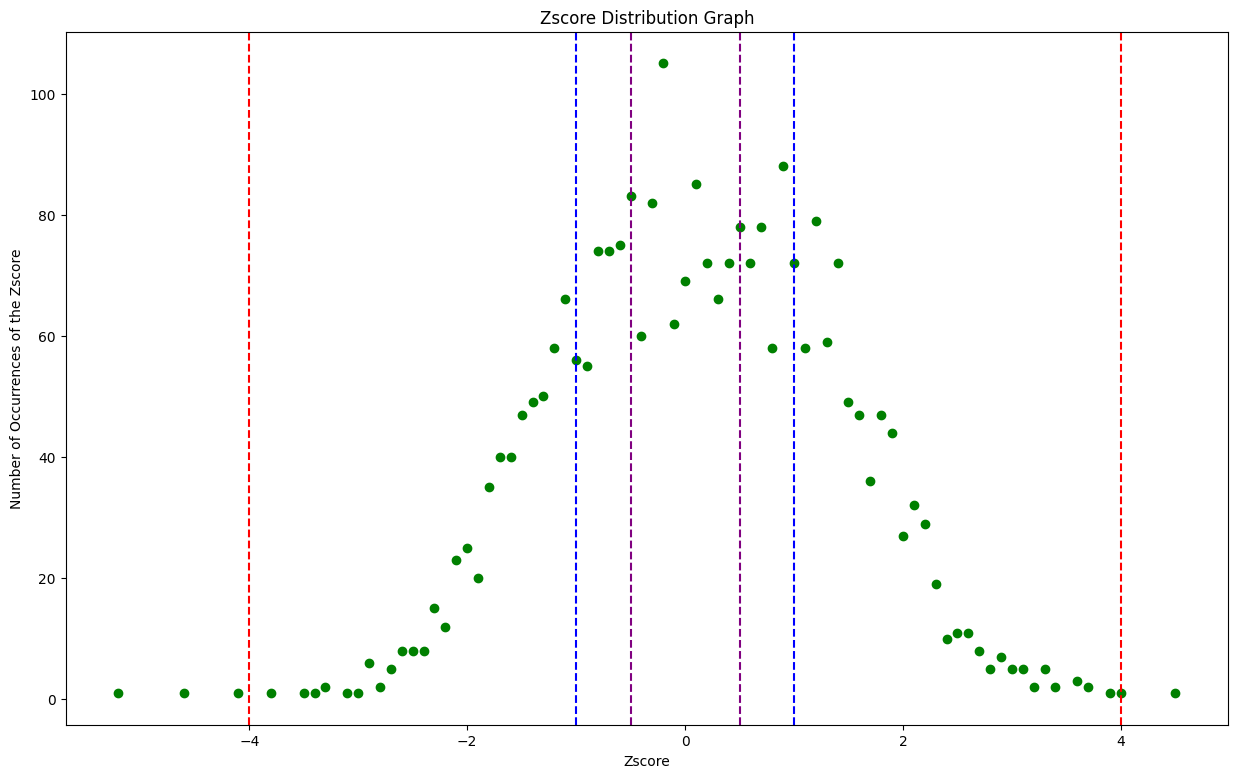

In [36]:
fig, ax = plt.subplots(figsize=(15, 9))
for z in zscore_freq:
    ax.plot(z, zscore_freq[z], 'go')

ax.axvline(x = -1, color='blue', linestyle='--')
ax.axvline(x = 1, color='blue', linestyle='--')
ax.axvline(x = -0.5, color='purple', linestyle='--')
ax.axvline(x = 0.5, color='purple', linestyle='--')
ax.axvline(x = -4.0, color='red', linestyle='--')
ax.axvline(x = 4.0, color='red', linestyle='--')
ax.set_title('Zscore Distribution Graph')
ax.set_xlabel('Zscore')
ax.set_ylabel('Number of Occurrences of the Zscore')
fig.show()

# Experiments and Results

### Enhanced (OPTICS AND PCA) Random Alphas

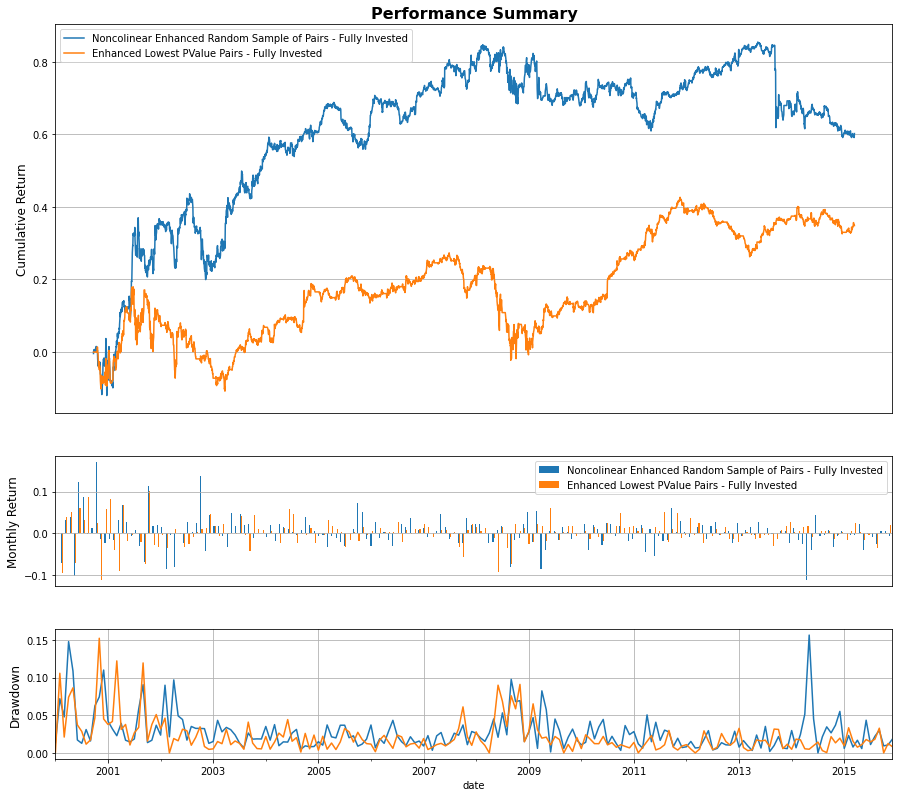

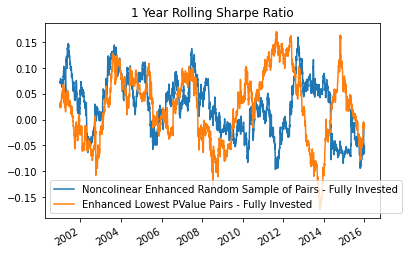

Noncolinear Enhanced Random Sample of Pairs - Fully Invested


return    sharpe   sortino  drawdown  turnover  long count  \
year                                                                    
2000     0.255526  1.153159  1.831026  0.147667  0.223365    6.932540   
2001     0.150285  0.965636  1.436826  0.130224  0.164941    7.475806   
2002     0.021873  0.136842  0.207871  0.214124  0.183131    5.468254   
2003     0.138937  1.377507  2.325635  0.074601  0.208050    3.920635   
2004     0.112223  1.366649  1.941717  0.044677  0.152118    4.416667   
2005     0.011659  0.157085  0.253165  0.122446  0.218705    5.603175   
2006     0.031653  0.441480  0.626906  0.068105  0.216939    5.741036   
2007     0.073265  0.797161  1.619835  0.079153  0.195394    6.494024   
2008    -0.057339 -0.342960 -0.453555  0.160390  0.157797    4.632411   
2009    -0.037030 -0.299832 -0.385314  0.137586  0.146366    5.321429   
2010     0.026122  0.315537  0.537523  0.069101  0.227660    4.230159   
2011    -0.013422 -0.156608 -0.240427  0.137476  0.216772    4.428571   
2012     0.042859  0.746488  1.121426  0.030493  0.178729    5.880000   
2013     0.091885  1.387573  2.373862  0.035221  0.181847    6.305556   
2014    -0.196362 -1.119456 -1.160794  0.222778  0.105361    3.996032   
2015    -0.050091 -0.819221 -1.206718  0.089156  0.185213    6.801587   
Overall  0.602042  0.310433  0.406111  0.244813  0.252502    5.475280   

         short count  
year                  
2000        5.932540  
2001        6.475806  
2002        4.468254  
2003        2.920635  
2004        3.416667  
2005        4.603175  
2006        4.741036  
2007        5.494024  
2008        3.632411  
2009        4.321429  
2010        3.230159  
2011        3.428571  
2012        4.880000  
2013        5.305556  
2014        2.996032  
2015        5.801587  
Overall     4.475280


Enhanced Lowest PValue Pairs - Fully Invested


return    sharpe   sortino  drawdown  turnover  long count  \
year                                                                    
2000     0.077525  0.376368  0.578032  0.152125  0.307471    6.972222   
2001    -0.058836 -0.319339 -0.440438  0.223841  0.179854    7.491935   
2002    -0.019968 -0.245539 -0.330321  0.143691  0.157453    7.317460   
2003     0.089639  1.258519  2.071053  0.046711  0.179367    7.488095   
2004     0.061708  0.709889  1.131535  0.049241  0.114718    7.595238   
2005     0.004917  0.084201  0.124118  0.072763  0.185639    7.230159   
2006     0.061660  1.035804  1.631925  0.029039  0.183897    7.370518   
2007    -0.018656 -0.282184 -0.391771  0.118304  0.209967    8.079681   
2008    -0.124468 -0.704445 -1.040707  0.235240  0.118271    7.707510   
2009     0.058584  0.529043  0.747291  0.081674  0.121624    7.527778   
2010     0.099369  1.331165  2.258775  0.032593  0.176890    7.813492   
2011     0.136219  1.956812  2.929662  0.045108  0.228802    7.269841   
2012     0.013456  0.247576  0.344619  0.048208  0.163286    7.144000   
2013    -0.080320 -1.552952 -2.200194  0.120394  0.160164    7.634921   
2014     0.062121  1.202864  1.842071  0.053063  0.177561    7.908730   
2015    -0.014414 -0.255355 -0.367636  0.065493  0.180237    7.805556   
Overall  0.348536  0.209609  0.283850  0.263429  0.244387    7.522484   

         short count  
year                  
2000        5.972222  
2001        6.491935  
2002        6.317460  
2003        6.488095  
2004        6.595238  
2005        6.230159  
2006        6.370518  
2007        7.079681  
2008        6.707510  
2009        6.527778  
2010        6.813492  
2011        6.269841  
2012        6.144000  
2013        6.634921  
2014        6.908730  
2015        6.805556  
Overall     6.522484

In [12]:
from sif.pairstrading.alphas import Enhanced_Random, Enhanced_Lowest_PValue
alphas = [Enhanced_Random(reset=90, npairs=10, exit=0.5), 
          Enhanced_Lowest_PValue(reset=90, npairs=10, exit=0.5)]
returns, holdings = backtester_15y.backtest(alphas, processes=None)
metrics.summary_plot(returns, source=['Noncolinear Enhanced Random Sample of Pairs - Fully Invested', 
                                      'Enhanced Lowest PValue Pairs - Fully Invested'])
get_rolling_sharpe(returns)
get_analytics(alphas, returns, holdings)

# END NOTEBOOK 1

## Alpha Search Optimization (Parameter Optimization)

Previously, we used a z-score of $1.0$ as the open threshold and $0.5$ as the close threshold for our trades, which are entirely arbitrary. While our intuition can have us use different open and close values based on what we think will work best, we both came up with different conclusions on our own. Rather than guessing and moving forward, let us Alpha Search from our SIF Infrastructure to test multiple values of our exit condition simultaneously with multiprocessing. A demo on parameter optimization can be found in the SIF Docs.

Done!: 100%|██████████| 18/18 [2:52:14<00:00, 574.15s/it]


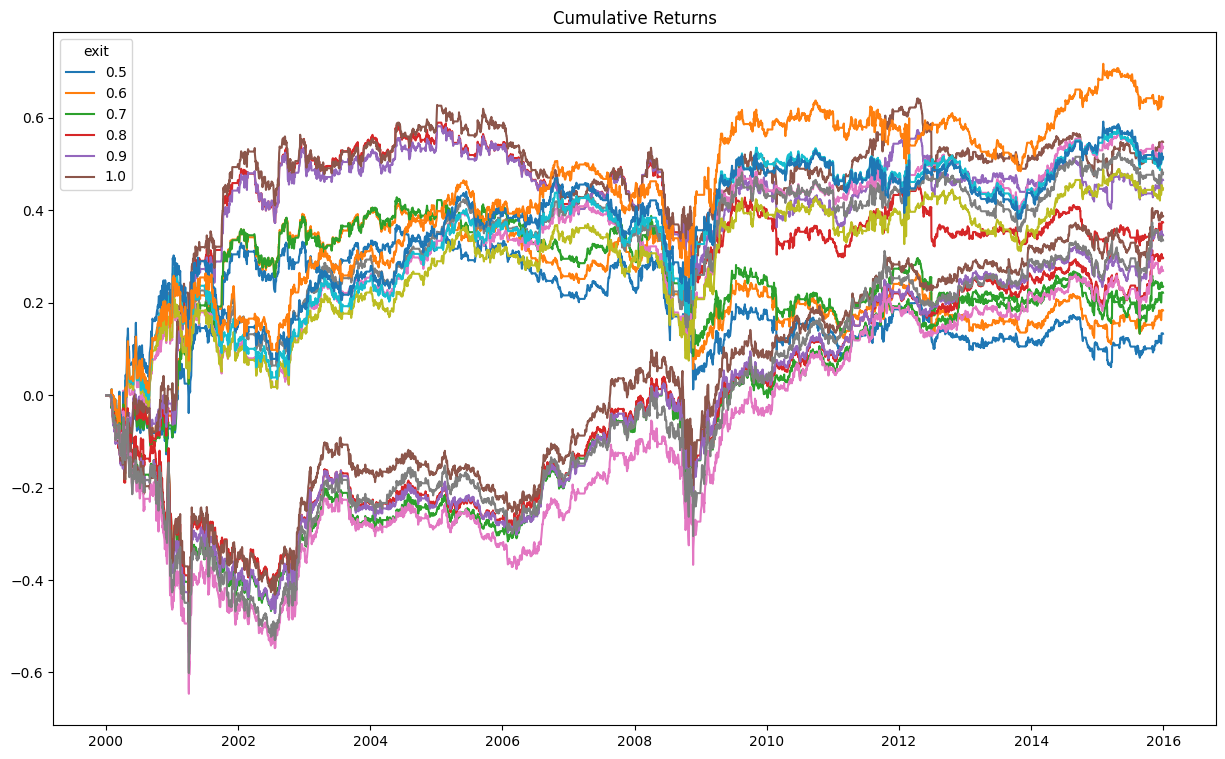

In [6]:
from sif.pairstrading.alphas import Enhanced_Lowest_PValue
param_grid = {'reset': [60, 90, 150], 'npairs': [10], 'exit': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]}
result = alpha_search.grid_search(Enhanced_Lowest_PValue, backtester_15y, 'return', param_grid, processes=6)
fig, ax = plt.subplots(figsize=(15,9))
ax.plot(result.alpha_returns.cumsum())
plt.legend(param_grid['exit'], title='exit')
plt.title('Cumulative Returns')
plt.show()

## Further Improvements

### Adding a Stop Loss

See `alphas.py` for implementation.

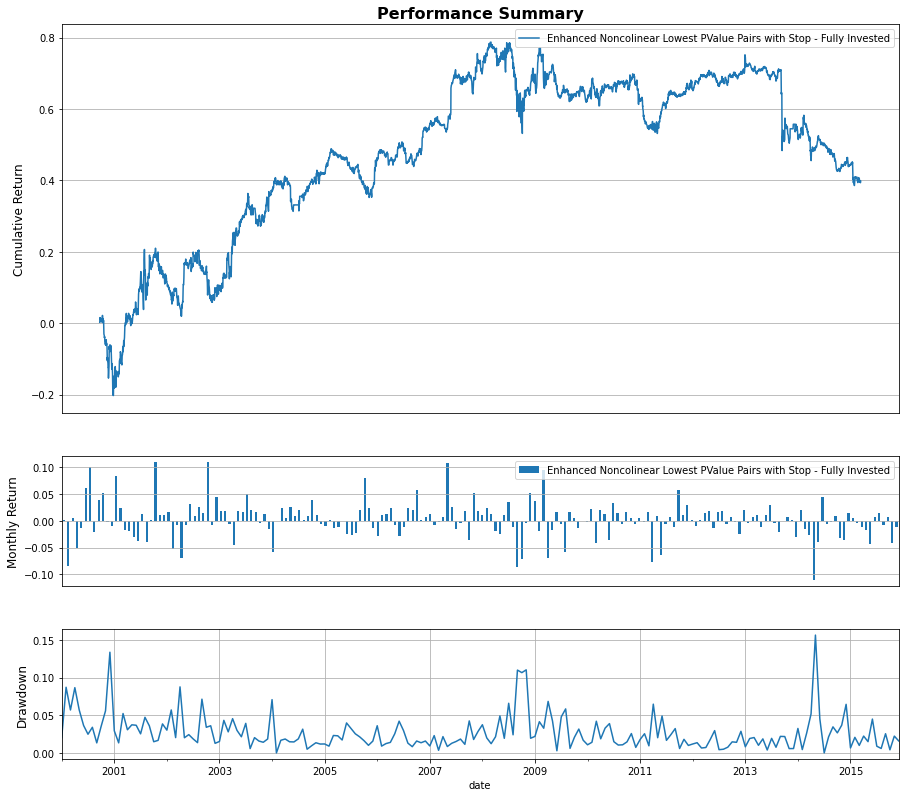

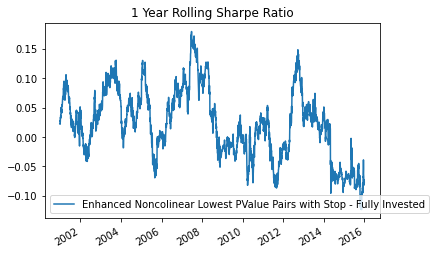

Enhanced Noncolinear Lowest PValue Pairs with Stop - Fully Invested


return    sharpe   sortino  drawdown  turnover  long count  \
year                                                                    
2000     0.078513  0.352270  0.608114  0.205606  0.202499    6.503968   
2001     0.108700  0.757564  1.369185  0.177348  0.175878    7.032258   
2002     0.105012  0.729308  1.139363  0.138215  0.193375    5.202381   
2003     0.096571  0.920485  1.431703  0.088489  0.177305    3.698413   
2004     0.081022  0.932972  1.170048  0.070658  0.151582    4.023810   
2005     0.001943  0.025213  0.043151  0.114526  0.245173    5.309524   
2006     0.082888  1.210158  1.669898  0.067483  0.230408    5.697211   
2007     0.175604  1.643451  3.847010  0.066581  0.214815    5.239044   
2008    -0.072812 -0.349541 -0.468050  0.237746  0.181361    4.185771   
2009    -0.015599 -0.118053 -0.146373  0.144713  0.150957    5.492063   
2010     0.031125  0.379460  0.626143  0.075670  0.218014    4.305556   
2011    -0.027125 -0.258708 -0.360622  0.156415  0.236850    3.996032   
2012     0.023894  0.417447  0.620848  0.037853  0.165381    6.008000   
2013     0.043874  0.685499  1.314819  0.052792  0.164771    6.563492   
2014    -0.226014 -1.278613 -1.344383  0.241479  0.103605    4.019841   
2015    -0.089668 -1.214842 -1.206210  0.132392  0.177162    5.964286   
Overall  0.397929  0.197158  0.258748  0.369930  0.253220    5.200000   

         short count  
year                  
2000        5.503968  
2001        6.032258  
2002        4.202381  
2003        2.698413  
2004        3.023810  
2005        4.309524  
2006        4.697211  
2007        4.239044  
2008        3.185771  
2009        4.492063  
2010        3.305556  
2011        2.996032  
2012        5.008000  
2013        5.563492  
2014        3.019841  
2015        4.964286  
Overall     4.200000

In [9]:
from sif.pairstrading.alphas import Enhanced_Noncolinear_Stop_Lowest_PValue1
alphas = [Enhanced_Noncolinear_Stop_Lowest_PValue1(reset=90, npairs=10, 
                                                   exit=0.5, stop=3.5)]
returns, holdings = backtester_15y.backtest(alphas, processes=None)
metrics.summary_plot(returns, source=['Enhanced Noncolinear Lowest PValue Pairs with Stop - Fully Invested'])
get_rolling_sharpe(returns)
get_analytics(alphas, returns, holdings)

## Testing2 - Alpha For Parameter Optimization

After further experimentation, we realized that limiting the enter and exit parameters to being between $1.0$ and $0.5$ was drastically reducing our potential returns. In a second optimization, we widen the span of enter and exit conditions that we are testing for, as well as introduce some variability in the npairs parameter to see if more pairs tends to outperform less pairs or vice versa. Ultimately, increasing the number of parameters we run during parameter optimization becomes more expensive with the greater dimension of the parameter grid, so we limit the number of enter and exit conditions tested to $3$.

Below is a sample implementation of Testing2 that demonstrates the greater returns that can be achieved with larger enter/exit conditions.

Testing2: 100%|████████████████████████████████████████████████████████████████████████| 1/1 [24:45<00:00, 1485.29s/it]


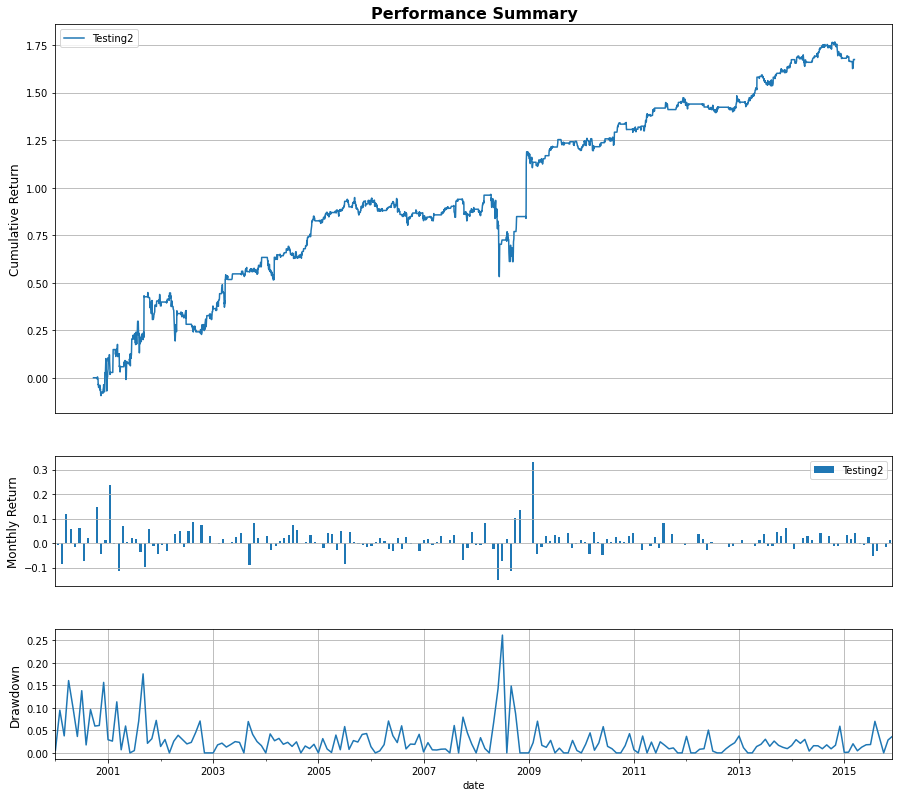

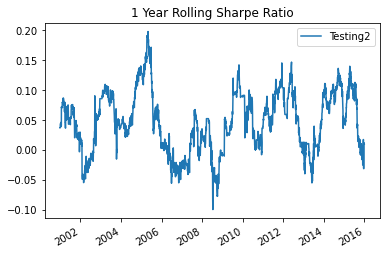

Testing2


return    sharpe   sortino  drawdown  turnover  long count  \
year                                                                    
2000     0.190557  0.585957  0.891046  0.173314  0.251064    2.015873   
2001     0.090761  0.297181  0.435409  0.239586  0.212922    1.778226   
2002     0.265230  1.357154  2.784402  0.113018  0.225575    1.793651   
2003     0.102171  0.631933  1.229730  0.114063  0.165426    1.952381   
2004     0.220638  2.107772  3.126629  0.062087  0.287157    2.115079   
2005     0.019449  0.185209  0.241076  0.088741  0.225565    2.138889   
2006    -0.055657 -0.520403 -0.601413  0.134300  0.191384    1.848606   
2007     0.062464  0.554189  0.720506  0.110819  0.204950    1.824701   
2008    -0.047507 -0.161365 -0.209454  0.364913  0.197425    1.687747   
2009     0.382127  1.403481  4.713199  0.082208  0.145207    1.710317   
2010     0.062050  0.622543  0.860710  0.064261  0.164184    1.821429   
2011     0.126734  1.647225  2.423373  0.051158  0.202883    1.539683   
2012    -0.008720 -0.125661 -0.158959  0.062447  0.151961    1.588000   
2013     0.164678  1.490895  2.794521  0.056471  0.211481    2.198413   
2014     0.085834  0.838335  1.259949  0.059291  0.241453    2.198413   
2015     0.013716  0.155835  0.200139  0.131959  0.227918    1.857143   
Overall  1.674527  0.579082  0.873471  0.364913  0.236918    1.879503   

         short count  
year                  
2000        1.015873  
2001        0.778226  
2002        0.793651  
2003        0.952381  
2004        1.115079  
2005        1.138889  
2006        0.848606  
2007        0.824701  
2008        0.687747  
2009        0.710317  
2010        0.821429  
2011        0.539683  
2012        0.588000  
2013        1.198413  
2014        1.198413  
2015        0.857143  
Overall     0.879503

In [13]:
from sif.pairstrading.alphas import Testing2
alphas = [Testing2(90, 10, 2.25, 1.75, 3.5)]
returns, holdings = backtester_15y.backtest(alphas, processes=None)
metrics.summary_plot(returns, source=['Testing2'])
get_rolling_sharpe(returns)     
get_analytics(alphas, returns, holdings)

## Parameter Optimization

In [6]:
param_grid = {'reset': [90], 'npairs': [10, 25], 'enter': [2, 2.5, 3], 
              'exit': [1.0, 1.5, 2], 'stop': [3.5]}
result = alpha_search.grid_search(Testing2, backtester_15y, 
                                  'return', param_grid, processes=None)
result.__dict__['results']

    param_reset  param_npairs  param_enter  param_exit  param_stop  \
0            90            10          2.0         1.0         3.5   
1            90            10          2.0         1.5         3.5   
2            90            10          2.0         2.0         3.5   
3            90            10          2.5         1.0         3.5   
4            90            10          2.5         1.5         3.5   
5            90            10          2.5         2.0         3.5   
6            90            10          3.0         1.0         3.5   
7            90            10          3.0         1.5         3.5   
8            90            10          3.0         2.0         3.5   
9            90            25          2.0         1.0         3.5   
10           90            25          2.0         1.5         3.5   
11           90            25          2.0         2.0         3.5   
12           90            25          2.5         1.0         3.5   
13           90     

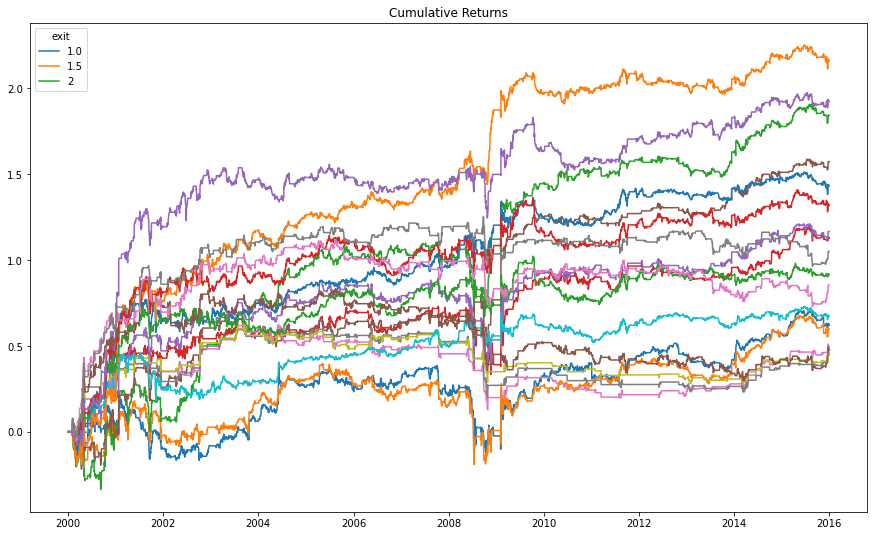

In [5]:
fig, ax = plt.subplots(figsize=(15,9))
ax.plot(result.alpha_returns.cumsum())
plt.legend(param_grid['exit'], title='exit')
plt.title('Cumulative Returns')
plt.show()

## Parameter Optimization Notes

It is important to understand the results of the grid search beyond just which alpha performed the best $(90, 25, 2.0, 2.0, 3.5)$.

Quickly we notice that

- $25$ pairs outperformed $10$ pairs in $7/9$ combinations of the other parameters

- exit of $2.0$ performed the best in $5/6$ combinations of npairs and enter

- With $10$ pairs, the enter condition of $2.5$ clearly seems to outperform. However, with $25$ pairs, is it not completely clear whether an enter of $2$ or $2.5$ is best. Despite this, we can still clearly see that the enter of $3.0$ performs the worst.

Additionally, a question may now be raised as to the validity of trading pairs with the same enter and exit parameter of $2.0$. However, due to the nature of calculating a rolling z-score, it may be very common for the enter and exit of a paticular trade to happen at a z-score of $2.0$, but those z-scores representing completely different realized spreads. Furthermore, it may also be that large moves drive the relationship between pairs, allowing the enter and exit z-score of $2.0$ to successfully trade.


## Validating Optimal Parameters - Traced

Throughout our development process, we repeatedly ran into bugs where the pairs trading was not actually working the way it shold have. For example, we may have not actually been opening trades when the threshold was reached, or not properly exiting when we wanted to. To remedy this, we created an alpha that displays the z-score and closing prices as it runs, allowing us to check that our implementation is working as expected. This was immensely useful for making sure our final alpha is bug free.

Specifically, since we are now using enter and exit at the same z-score value, we want to check and see the profitable trades are actually being made the way we think they are.

By lining up the $3$ printed dataframes (z-score, stock prices, and spread), we can see when trades are entered and exited, and the corresponding share prices and spread between share priced for the involved securities. With this information, we can validate that spread does indeed decrease a large portion of the time between when trades are opened and closed, which is the strategy's profit.

In [17]:
class Traced(AbstractAlpha):
    def __init__(self, reset: int, npairs: int, enter: int, exit: int, stop: int):
        self.name = 'Traced'
        self.lookback = reset
        self.factor_list = ['close']
        self.universe_size = 500 
        self.pairs = None
        self.print = True
        self.reset = reset
        self.npairs = npairs
        self.enter = enter
        self.exit = exit
        self.stop = stop
        self.holdings = np.zeros(self.universe_size)
        self.period = 1
        self.day = 0
        self.day_counter = 0
        self.factors = ['Zscore', 'Close Prices', 'Spread']
        self.factor_data = {factor:pd.DataFrame(np.zeros((self.reset, self.npairs))) for factor in self.factors}

    def zscore(self, series: array_1d) -> array_1d:
        return (series - series.mean()) / np.std(series)
    
    def form_pairs(self, df: pd.DataFrame) -> array_1d:
        df = pd.DataFrame(df)
        clustering_df = df.dropna()
        n = df.shape[1]
        # Obtain transformed data and clusters using above functions.
        transformed_data = self.reduce_dimensionality(clustering_df)
        labels = self.cluster_optics(transformed_data)
        # Run the statistical cointegration test.
        pvalue_matrix = np.ones((n, n))
        keys = df.keys()
        pairs = []
        pairsDict = {}
        # Iterate through our universe of 500 stocks.
        for i in range(n):
            for j in range(i + 1, n):
                # Only consider non-outliers in the same cluster.
                if labels[i] != -1 and labels[j] != -1 and labels[i] == labels[j]:
                    S1 = df[keys[i]]
                    S2 = df[keys[j]]
                    coint_df = pd.DataFrame({'S1': S1, 'S2': S2}).dropna()
                    S1 = coint_df['S1']
                    S2 = coint_df['S2']
                    result = coint(S1, S2)
                    pvalue = result[1]
                    pvalue_matrix[i, j] = pvalue
                    # Take pairs that reject the null hypothesis.
                    if pvalue < 0.05:
                        pairsDict[(i,j)] = pvalue
        # Sort the pairs by lowest pvalue.
        keys, values = list(pairsDict.keys()), list(pairsDict.values())
        sorted_value_index = np.argsort(values)
        sorted_dict = {keys[i]: values[i] for i in sorted_value_index}
        # Remove duplicate stocks.
        new_dict, seen = {}, set()
        for (i, j) in sorted_dict:
            if i not in seen and j not in seen:
                new_dict[(i, j)] = sorted_dict[(i,j)]
                seen.add(i)
                seen.add(j)
        # Obtain top npairs pairs if possible.
        pairs = list(new_dict.keys()) if len(new_dict) < self.npairs else list((new_dict.keys()))[0:self.npairs]
        return pairs
    
    def reduce_dimensionality(self, df: pd.DataFrame) -> pd.DataFrame:
        rets = df.pct_change().dropna()
        rets = rets.T
        pca = PCA(n_components = 0.9, svd_solver='full')
        transformed_data = pca.fit_transform(rets)
        return transformed_data
        
    def cluster_optics(self, transformed_data: array_1d) -> array_1d:
        optics = OPTICS(min_samples = 2)
        labels = optics.fit_predict(transformed_data)
        return labels

    def make_factors(self):
        self.factor_data = {factor:pd.DataFrame(np.zeros((self.reset, len(self.pairs)))) for factor in self.factors}
        for factor in self.factor_data:
            self.factor_data[factor] = self.factor_data[factor].set_axis(self.pairs, axis="columns")
            new_axis = [i for i in range(self.reset)]
            self.factor_data[factor] = self.factor_data[factor].set_axis(new_axis, axis="rows")
            self.factor_data[factor] = self.factor_data[factor].rename_axis(f"{factor} of Pairs", axis="columns")

    def generate_day(self, day: int, data: Dict[pd.DataFrame]) -> List[float]:
        # Print factor data.
        if self.day == 90:
            self.day = 0
            if self.print:
                for factor in self.factors:
                    print(f"Trading Window {self.period}: {factor}")
                    print(self.factor_data[factor].to_markdown())
                    print()
            self.period += 1
        # Generate new pairs.
        if self.day_counter == 0:
            self.day_counter = self.reset
            self.holdings = np.zeros(self.universe_size)
            self.pairs = self.form_pairs(data['close'])
            self.factor_data = {factor:pd.DataFrame(np.zeros((self.reset, self.npairs))) for factor in self.factors}
            self.make_factors()

        # Fill nans in our data so information is printed properly.
        data = pd.DataFrame(data['close']).fillna(method="ffill").fillna(method="bfill")
        # Iterate through all identified pairs.
        for p in self.pairs:
            # *** FACTOR DATA *** #
            FIRST, SECOND = p[0], p[1]
            # Define values that will be added to the factor dataframes.
            spread = data[FIRST] - data[SECOND]
            z_score = self.zscore(spread).tail(1).values[0]
            diff = spread[day]
            close_price = ({round(data[p[0]][day], 2)} , {round(data[p[1]][day], 2)})
            # Note that we need a separate for loop for the factors so that
            # all data is recorded for each data.
            for factor in self.factors:
                # ZScore dataframe update.
                if factor == 'Zscore':
                    # This is where we'd long SECOND, short FIRST.
                    if z_score >= self.enter and z_score < self.stop:
                        self.factor_data[factor][p][self.day] = f"OPEN {round(z_score, 2)}"
                    # Exit the trade.
                    elif abs(z_score) <= self.exit:
                        self.factor_data[factor][p][self.day] = f"CLOSED {round(z_score, 2)}"
                    # This is where we'd long FIRST, short SECOND.
                    elif z_score <= -self.enter and z_score >= -self.stop:
                        self.factor_data[factor][p][self.day] = f"OPEN {round(z_score, 2)}"
                # Close prices dataframe update.
                elif factor == 'Close Prices':
                    self.factor_data[factor][p][self.day] = close_price
                # Spread dataframe update.
                elif factor == 'Spread':
                    self.factor_data[factor][p][self.day] = round(diff, 2)
            
            # Our trading methodology for the alphs is implemented below.
            # Long SECOND, short FIRST.
            if z_score >= self.enter and z_score <= self.stop:
                    self.holdings[FIRST] = -1
                    self.holdings[SECOND] = 1
            # Exit the trade.
            elif abs(z_score) < self.exit:
                self.holdings[FIRST] = 0
                self.holdings[SECOND] = 0
            # Stop loss condition.
            elif abs(z_score) > self.stop:
                temp = data.dropna()
                S1, S2 = temp[FIRST], temp[SECOND]
                result = coint(S1, S2)
                pvalue = result[1]
                if pvalue >= 0.05:
                    self.holdings[FIRST] = 0
                    self.holdings[SECOND] = 0
                    self.pairs.remove(p)
            # Long FIRST, short SECOND.
            elif z_score <= -self.enter and z_score >= -self.stop:
                self.holdings[FIRST] = 1
                self.holdings[SECOND] = -1
            
        # At the end of the trading day, decrement the day counter.
        self.day += 1
        self.day_counter -= 1
        return op.weight(self.holdings)

Traced:   0%|                                                                                    | 0/1 [00:00<?, ?it/s]

Trading Window 1: Zscore
|    | (11, 12)     | (290, 291)   | (287, 369)   | (286, 494)   | (300, 390)   | (284, 476)   | (282, 283)   | (270, 271)   | (335, 336)   | (465, 466)   | (443, 444)   | (415, 416)   | (410, 411)   | (398, 399)   | (386, 387)   | (381, 382)   | (355, 356)   | (234, 235)   | (224, 225)   | (478, 479)   | (87, 88)     | (76, 77)     | (126, 265)   | (132, 133)   | (146, 147)   |
|---:|:-------------|:-------------|:-------------|:-------------|:-------------|:-------------|:-------------|:-------------|:-------------|:-------------|:-------------|:-------------|:-------------|:-------------|:-------------|:-------------|:-------------|:-------------|:-------------|:-------------|:-------------|:-------------|:-------------|:-------------|:-------------|
|  0 | 0.0          | 0.0          | 0.0          | 0.0          | 0.0          | CLOSED 1.0   | 0.0          | CLOSED 1.88  | 0.0          | 0.0          | CLOSED -0.5  | OPEN 2.57    | CLOSED 1.88  | CLOSED -0

Traced: 100%|██████████████████████████████████████████████████████████████████████████| 1/1 [38:12<00:00, 2292.36s/it]


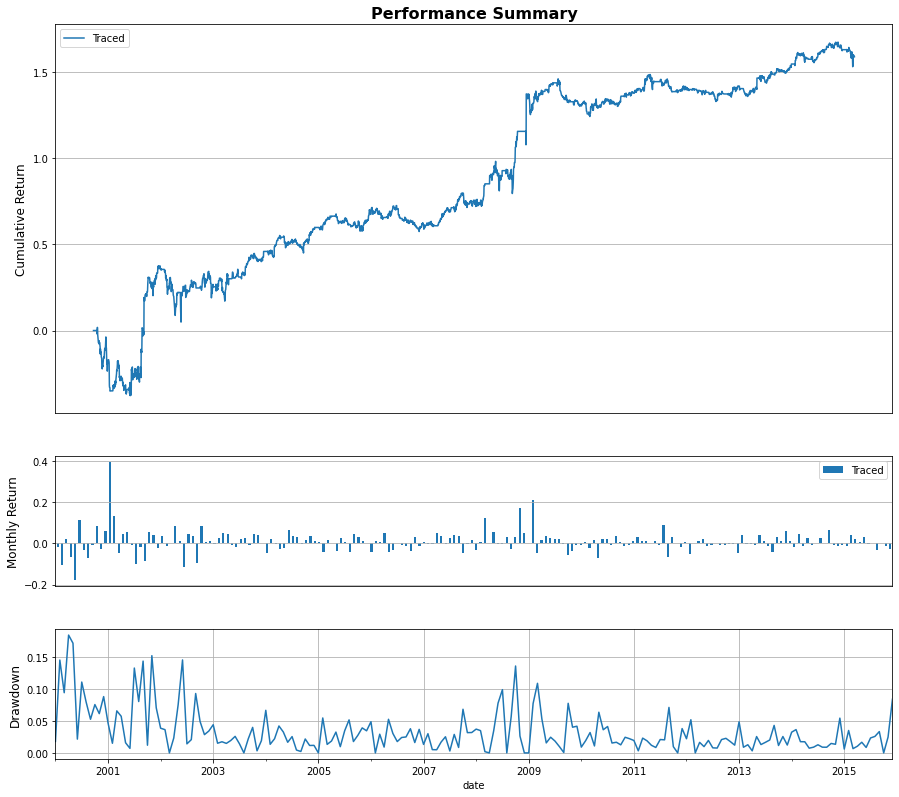

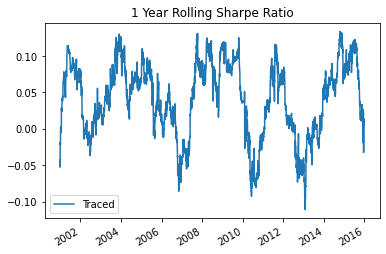

Traced


return    sharpe   sortino  drawdown  turnover  long count  \
year                                                                    
2000    -0.220826 -0.684316 -0.869835  0.347682  0.792695    2.865079   
2001     0.447450  1.132125  2.016213  0.289699  0.581036    2.641129   
2002     0.087276  0.444292  0.563896  0.167399  0.617170    2.682540   
2003     0.230631  1.960315  3.509820  0.054147  0.545496    2.932540   
2004     0.116590  1.050016  1.672935  0.095977  0.620334    3.242063   
2005     0.027409  0.266005  0.380002  0.097213  0.695273    2.936508   
2006    -0.079593 -0.777865 -0.943407  0.141548  0.627356    2.904382   
2007     0.147996  1.489372  2.201830  0.081128  0.613640    2.996016   
2008     0.398982  1.703864  2.515293  0.181506  0.609907    2.671937   
2009     0.180979  0.610175  1.342213  0.130546  0.528076    2.464286   
2010    -0.021688 -0.214837 -0.286094  0.092489  0.656707    3.198413   
2011     0.114138  1.030948  1.445861  0.084887  0.545409    2.424603   
2012    -0.047915 -0.704040 -0.911527  0.089240  0.525280    2.660000   
2013     0.081531  0.764732  1.381991  0.058885  0.572210    3.186508   
2014     0.117681  1.246183  1.837712  0.055758  0.615695    3.023810   
2015     0.007950  0.074003  0.096360  0.135370  0.566767    3.202381   
Overall  1.588591  0.530284  0.781798  0.347682  0.641662    2.877267   

         short count  
year                  
2000        1.865079  
2001        1.641129  
2002        1.682540  
2003        1.932540  
2004        2.242063  
2005        1.936508  
2006        1.904382  
2007        1.996016  
2008        1.671937  
2009        1.464286  
2010        2.198413  
2011        1.424603  
2012        1.660000  
2013        2.186508  
2014        2.023810  
2015        2.202381  
Overall     1.877267

In [18]:
alphas = [Traced(reset=90, npairs=25, enter=2.0, exit=2.0, stop=3.0)] 
returns, holdings = backtester_15y.backtest(alphas, processes=None)
metrics.summary_plot(returns, source=['Traced'])
get_rolling_sharpe(returns)
get_analytics(alphas, returns, holdings)

In [8]:
get_analytics(alphas, returns, holdings)

Traced


return    sharpe   sortino  drawdown  turnover  long count  \
year                                                                    
2000     0.110642  0.362670  0.519957  0.210720  0.460284    1.781746   
2001     0.219221  1.047997  1.609221  0.098393  0.415198    1.685484   
2002     0.132558  0.781521  1.050702  0.118760  0.303161    1.559524   
2003     0.127429  1.611962  2.930102  0.066988  0.210638    1.317460   
2004     0.201067  2.692431  5.421256  0.032261  0.303030    1.365079   
2005     0.123806  1.267127  1.958196  0.089524  0.476695    1.722222   
2006     0.116194  1.122661  1.911084  0.090583  0.337571    1.545817   
2007     0.291925  1.829518  5.879664  0.040268  0.389957    1.482072   
2008     0.042830  0.180011  0.216649  0.172819  0.272175    1.498024   
2009     0.094357  0.492474  0.773353  0.153328  0.218169    1.432540   
2010    -0.057628 -0.870142 -1.173367  0.091804  0.206383    1.515873   
2011     0.068131  1.034314  1.702577  0.049826  0.285513    1.384921   
2012     0.130099  1.671937  2.271843  0.059803  0.370798    1.552000   
2013     0.015470  0.284266  0.357610  0.033562  0.404328    1.896825   
2014    -0.083295 -0.757788 -0.971570  0.132339  0.215456    1.500000   
2015    -0.049431 -0.601490 -0.756788  0.117043  0.398945    1.884921   
Overall  1.483376  0.623532  0.898945  0.210720  0.351093    1.570186   

         short count  
year                  
2000        0.781746  
2001        0.685484  
2002        0.559524  
2003        0.317460  
2004        0.365079  
2005        0.722222  
2006        0.545817  
2007        0.482072  
2008        0.498024  
2009        0.432540  
2010        0.515873  
2011        0.384921  
2012        0.552000  
2013        0.896825  
2014        0.500000  
2015        0.884921  
Overall     0.570186

## Optimizing the Stop Loss Parameter

After completing our above optimizations, it was suggested that a lower stoploss might perform better. Thus, we wanted to see how a stoploss of $3.0$ might perform relative to our original stoploss of $3.5$.

   param_reset  param_npairs  param_enter  param_exit  param_stop  \
0           90            25            2           2         3.5   
1           90            25            2           2         3.0   

                                              params     score  
0  {'reset': 90, 'npairs': 25, 'enter': 2, 'exit'...  2.159327  
1  {'reset': 90, 'npairs': 25, 'enter': 2, 'exit'...  1.387040  


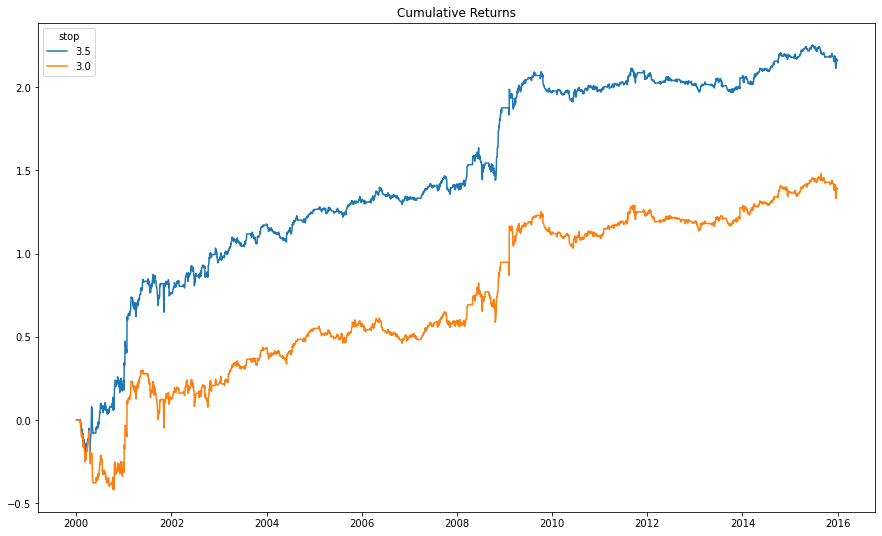

In [126]:
from sif.pairstrading.alphas import Testing2
param_grid = {'reset': [90], 'npairs': [25], 'enter': [2], 'exit': [2], 'stop': [3.5, 3.0]}
result = alpha_search.grid_search(Testing2, backtester_15y, 'return', param_grid, processes=None)
print(result.__dict__['results'])
fig, ax = plt.subplots(figsize=(15,9))
ax.plot(result.alpha_returns.cumsum())
plt.legend(param_grid['stop'], title='stop')
plt.title('Cumulative Returns')
plt.show()

Although we would have liked to run this test on a cross-section with respect to the other parameters, it would have been very computationally expensive. Thus, we just ran a simple test and elected to keep a stop condition of $z > |3.5|$.


We are especially skeptical of potential overfitting here, as we can see the difference in performance comes almost exclusively from $2001$, when the low stoploss seems to have cut gains short. However, we see no reason to change our stoploss from the original $3.5$.

## Pair Validation Techniques Hurst Exponent and Profitability

Next, we implement Hurst exponent as an attempt at further validating the profitability of our selected pairs before trading on them.

https://www.sciencedirect.com/science/article/pii/S037843712100964X?via%3Dihub

The Hurst Exponent measures long term memory and fractility of a time series. Let us denote a Hurst Exponent value as $H$. A Brownian random process is given by $H = 0.5$, while $0.5 < H \leq 1.0$ indicates a trending behavior. If $0 \leq H < 0.5$, the time series exhibits a mean reverting behavior. This is optimal for a pairs trading strategy.

Since in general, $H != 0.5 \implies$ the time series exhibits some sort of predictable pattern, we can use this metric to better trade on trending/momentum strategies with large $H$ or mean reverting strategies like pairs trading with low $H$.

In the next alpha, we implement Hurst Exponent as a Validation technique to insure the pair is mean reverting in addition to cointegrated. We can consider weighting / selecting final pairs based on Hurst in a later alpha, but for now, we simply require a cutoff for the metric $x$, where $x < 0.5$.

The code for calculating Hurst comes from here: https://stackoverflow.com/questions/39488806/Hurst-exponent-in-python


HURST ON STOCKS

482 482
[0.48144515 0.2984089  0.37815051 0.38698298 0.45030502 0.58075875
 0.49961413 0.31982893 0.20190837 0.26541291 0.47369003 0.47265829
 0.38248461 0.50376813 0.40326177 0.26161414 0.49003071 0.34131983
 0.38380711 0.38642152 0.43879521 0.47765906 0.45307745 0.41096753
 0.33545483]
Mean: 0.3695022603170784
Min: -0.019756188364177255
Max: 0.6487146108643645
-0.019756188364177255
0.06921549557453441
0.08306626957374834
0.08751749492257242
0.09707956376054665
0.1187235182447071
0.12984934184485267


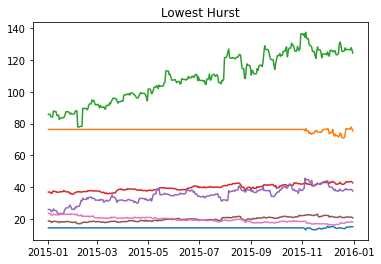

0.5761237520022303
0.5807587545828551
0.5977869733377006
0.621881428930192
0.6258500325187216
0.6322225309126616
0.6487146108643645


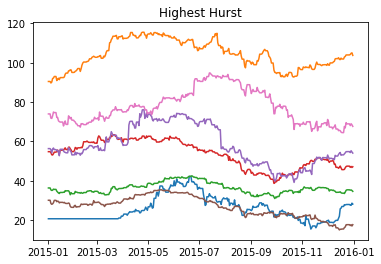

HURST ON PAIRS


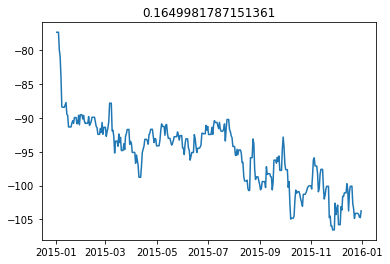

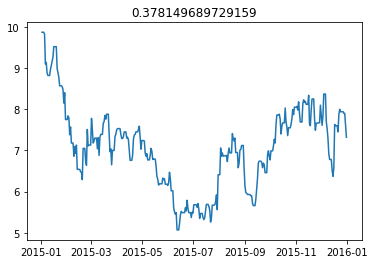

In [32]:
def hurst(p: array_1d) -> int:
    # Define variables for Hurst Exponent calulation.
    lags = range(2, 100)
    variancetau = []
    tau = []
    for lag in lags: 
        # Write the different lags into a vector to compute a set of taus.
        tau.append(lag) 
        # Define pp as the price difference.
        pp = np.subtract(p[lag:], p[:-lag])
        # Compute the variance on the difference in log returns.
        variancetau.append(np.var(pp))
    # We now have a set of tau or lags and a corresponding set of variances.
    m = np.polyfit(np.log10(tau), np.log10(variancetau), 1)
    hurst = m[0] / 2
    return hurst

# Print some general infomration about the Hurst values of for the S&P500.
print("HURST ON STOCKS\n")
print("Shape", len(hurst(close_data)), len(close_data.columns))
h_exp = hurst(close_data)
print("First 25 Hursts", h_exp[:25])
print("Mean:", h_exp.mean())
print("Min:", h_exp.min())
print("Max:", h_exp.max())

# Lowest Hursts plot.
indices = np.argsort(h_exp)[:7]
for i in indices:
    plt.plot(close_data.iloc[:, i])
    print(h_exp[i])
plt.title("Lowest Hurst")
plt.show()

# Highest Hursts plot.
indices2 = np.argsort(h_exp)[-7:]
for i in indices2:
    print(h_exp[i])
    plt.plot(close_data.iloc[:, i])
plt.title("Highest Hurst")
plt.show()

# Examining the Hurst Exponent value of a known cointegrated pair.
print("HURST ON PAIRS")
pair = ("ATVI", "STZ")
pair2 = ("AEE", "XEL")
tspair = close_data["ATVI"] - close_data["STZ"]
tspair2 = close_data["AEE"] - close_data["XEL"]
tspairs = (tspair, tspair2)
for i in tspairs:
    plt.plot(i)
    plt.title((hurst(list(i))))
    plt.show()

## Hurst Exploratory Data Analysis Notes

Clearly, we can see that lower $H$ values indeed seem to correspond to timeseries that exhibit mean reversion, while higher $H$ values seem to correspond to trending timeseries. Specifically, assets which had conditions which caused their prices not to move at all during part of the time period exhibit the lowest $H$ values.

In order to accomadate potentially inconsistent lookbacks, we make some small changes to the `hurst` function before implementing it in our alpha.

In [9]:
def hurst(p: array_1d, lag_num: int) -> int:
    # Define variables for Hurst Exponent calulation.
    lags = range(2, lag_num)
    variancetau = []
    tau = []
    for lag in lags: 
        # Write the different lags into a vector to compute a set of taus.
        tau.append(lag) 
        # Define pp as the price difference.
        pp = np.subtract(p[lag:], p[:-lag])
        # Compute the variance on the difference in log returns.
        variancetau.append(np.var(pp))
    # We now have a set of tau or lags and a corresponding set of variances.
    m = np.polyfit(np.log10(tau), np.log10(variancetau), 1)
    hurst = m[0] / 2
    return hurst

In [10]:
class Hurst_Cutoff(AbstractAlpha):
    def __init__(self, reset: int, npairs: int, enter: int, exit: int, 
                 stop: int, hurst_cutoff: int):
        self.name = 'HURST Cutoff'
        self.lookback = reset
        self.factor_list = ['close']
        self.universe_size = 500
        self.enter = enter
        self.pairs = None
        self.reset = reset
        self.npairs = npairs
        self.exit = exit
        self.stop = stop
        self.holdings = np.zeros(self.universe_size)
        self.day_counter = 0
        self.count = 0
        # Recall 0.5 means that the series reflects brownian motion.
        self.hurst = hurst_cutoff 

    def zscore(self, series: pd.Series) -> pd.Series:
        return (series - series.mean()) / np.std(series)

    def reduce_dimensionality(self, df: pd.DataFrame) -> pd.DataFrame:
        rets = df.pct_change().dropna()
        rets = rets.T
        pca = PCA(n_components = 0.9, svd_solver='full')
        transformed_data = pca.fit_transform(rets)
        return transformed_data
    
    def cluster_optics(self, transformed_data: np.ndarray) -> List[int]:
        optics = OPTICS(min_samples = 2)
        labels = optics.fit_predict(transformed_data)
        return labels
    
    def form_pairs(self, df: pd.DataFrame) -> List:
        df = pd.DataFrame(df).dropna()
        n = df.shape[1]
        # Obtain transformed data and clusters using above functions.
        transformed_data = self.reduce_dimensionality(df)
        labels = self.cluster_optics(transformed_data)
        # Now compute cointegration.
        keys = df.keys()
        pairs = []
        pairsDict = {}
        for i in range(n):
            for j in range(i + 1, n):
                # Assert that both stocks are in the same cluster and not outliers.
                if labels[i] != -1 and labels[j] != -1 and labels[i] == labels[j]:
                    S1 = df[keys[i]]        
                    S2 = df[keys[j]]
                    result = coint(S1, S2)
                    pvalue = result[1]
                    if pvalue < 0.05:
                        # Now check the Hurst Exponent value.
                        diff = list(S1 - S2)
                        lags = min(int(4 + len(diff) / 3), 100)
                        h_exp = hurst(pd.DataFrame(diff), lags)
                        if h_exp < self.hurst:
                            pairsDict[(i, j)] = pvalue
        # Sort the pairs by lowest pvalue.
        keys, values = list(pairsDict.keys()), list(pairsDict.values())
        sorted_value_index = np.argsort(values)
        sorted_dict = {keys[i]: values[i] for i in sorted_value_index}
        # Remove duplicate stocks.
        new_dict, seen = {}, set()
        for (i, j) in sorted_dict:
            if i not in seen and j not in seen:
                new_dict[(i, j)] = sorted_dict[(i,j)]
                seen.add(i)
                seen.add(j)
        # Choose npairs pairs if possible.
        if len(new_dict) < self.npairs:
            pairs = list(new_dict.keys())
        else:
            pairs = list((new_dict.keys()))[0:self.npairs]
        return pairs
    
    def generate_day(self, day: datetime.datetime, 
                     data: Dict[pd.DataFrame]) -> List[float]:
        # Create new pairs after 90 days.
        if self.day_counter == 0:
            self.day_counter = self.reset
            self.pairs = self.form_pairs(data['close'])
            self.holdings = np.zeros(self.universe_size)
        # Obtain just close price data.
        data = pd.DataFrame(data["close"])
        for p in self.pairs:
            FIRST, SECOND = p[0], p[1]
            spread = data[FIRST] - data[SECOND]
            z_score = self.zscore(spread).tail(1).values[0]
            # Long SECOND, short FIRST.
            if z_score >= self.enter and z_score <= self.stop:
                self.holdings[FIRST] = -1
                self.holdings[SECOND] = 1
            # Exit the trade.
            elif abs(z_score) <= self.exit:
                self.holdings[FIRST] = 0
                self.holdings[SECOND] = 0
            # Check stop loss condition.
            elif abs(z_score) > self.stop:
                temp = data.dropna()
                S1, S2 = temp[FIRST], temp[SECOND]
                result = coint(S1, S2)
                pvalue = result[1]
                if pvalue >= 0.05:
                    self.holdings[FIRST] = 0
                    self.holdings[SECOND] = 0
                    self.pairs.remove(p)
            # Long FIRST, short SECOND.
            elif z_score <= self.enter and z_score >= -self.stop:
                self.holdings[FIRST] = 1
                self.holdings[SECOND] = -1
            
        # At the end of the trading day, decrement the day counter.
        self.day_counter -= 1
        return op.weight(self.holdings)

HURST Cutoff:   0%|                                                                              | 0/1 [00:00<?, ?it/s]C:\Users\samrg\Git Repos\sif_project\sif\siftools\backtesters\full_backtesters.py:362: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  returns = pd.Series(index=self.trading_days)
HURST Cutoff: 100%|████████████████████████████████████████████████████████████████████| 1/1 [32:00<00:00, 1920.01s/it]


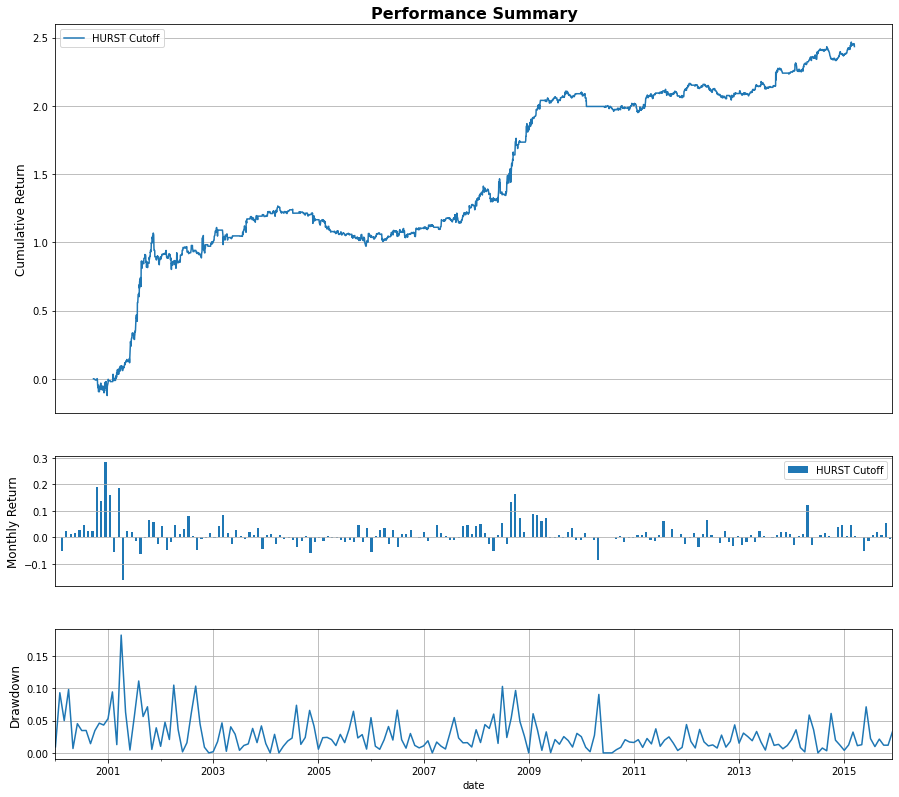

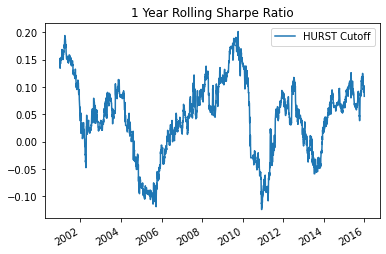

HURST Cutoff


return    sharpe   sortino  drawdown  turnover  long count  \
year                                                                    
2000     0.741919  2.394832  4.570957  0.124264  0.747624    2.599206   
2001     0.192978  0.644246  0.964880  0.240429  0.611784    2.548387   
2002     0.112270  0.532266  0.671572  0.125851  0.363506    1.646825   
2003     0.167664  1.290227  2.420218  0.050931  0.404965    1.642857   
2004    -0.135524 -1.241168 -1.450805  0.158832  0.255411    1.535714   
2005    -0.010347 -0.106241 -0.151911  0.109784  0.594315    2.896825   
2006     0.034303  0.309908  0.406534  0.066056  0.534251    2.131474   
2007     0.165390  1.447020  2.718182  0.071215  0.522405    2.513944   
2008     0.465828  1.805593  2.567029  0.117140  0.513591    2.063241   
2009     0.348460  2.285226  3.765721  0.060510  0.498212    2.063492   
2010    -0.109462 -1.549256 -1.622291  0.132381  0.275532    1.595238   
2011     0.137124  1.424213  2.248100  0.066403  0.519691    2.087302   
2012    -0.004584 -0.052400 -0.075122  0.062195  0.535364    2.084000   
2013     0.038577  0.490393  0.743179  0.081577  0.528490    2.670635   
2014     0.164259  1.057634  1.889264  0.064629  0.394587    1.873016   
2015     0.126210  1.317829  2.089116  0.097557  0.595745    2.289683   
Overall  2.435066  0.909091  1.365387  0.262388  0.525045    2.139627   

         short count  
year                  
2000        1.599206  
2001        1.548387  
2002        0.646825  
2003        0.642857  
2004        0.535714  
2005        1.896825  
2006        1.131474  
2007        1.513944  
2008        1.063241  
2009        1.063492  
2010        0.595238  
2011        1.087302  
2012        1.084000  
2013        1.670635  
2014        0.873016  
2015        1.289683  
Overall     1.139627

In [116]:
alphas = [Hurst_Cutoff(reset=90, npairs=10, enter=2.25, exit=1.75, stop=3.5, 
                       hurst_cutoff=0.5)]
returns, holdings = backtester_15y.backtest(alphas, processes=None)
metrics.summary_plot(returns, source=['HURST Cutoff'])
get_rolling_sharpe(returns)
get_analytics(alphas, returns, holdings)

In [117]:
class HURST_SORT(AbstractAlpha):
    def __init__(self, reset: int, npairs: int, enter: int, exit: int, 
                 stop: int, hurst_cutoff: int):
        self.name = 'HURST Sort'
        self.lookback = reset
        self.factor_list = ['close']
        self.universe_size = 500
        self.enter = enter
        self.pairs = None
        self.print = False
        self.reset = reset
        self.npairs = npairs
        self.exit = exit
        self.stop = stop
        self.holdings = np.zeros(self.universe_size)
        self.day_counter = 0
        self.count = 0
        # Recall 0.5 means that the series reflects brownian motion.
        self.hurst = hurst_cutoff 

    def zscore(self, series: pd.Series) -> pd.Series:
        return (series - series.mean()) / np.std(series)

    def reduce_dimensionality(self, df: pd.DataFrame) -> pd.DataFrame:
        rets = df.pct_change().dropna()
        rets = rets.T
        pca = PCA(n_components = 0.9, svd_solver='full')
        transformed_data = pca.fit_transform(rets)
        return transformed_data
    
    def cluster_optics(self, transformed_data: np.ndarray) -> List[int]:
        optics = OPTICS(min_samples = 2)
        labels = optics.fit_predict(transformed_data)
        return labels
    
    def form_pairs(self, df: pd.DataFrame) -> List:
        df = pd.DataFrame(df).dropna()
        n = df.shape[1]
        # Obtain transformed data and clusters using above functions.
        transformed_data = self.reduce_dimensionality(df)
        labels = self.cluster_optics(transformed_data)
        # Now compute cointegration.
        keys = df.keys()
        pairs = []
        pairsDict = {}
        for i in range(n):
            for j in range(i + 1, n):
                # Assert that both stocks are in the same cluster and not outliers.
                if labels[i] != -1 and labels[j] != -1 and labels[i] == labels[j]:
                    S1 = df[keys[i]]        
                    S2 = df[keys[j]]
                    result = coint(S1, S2)
                    pvalue = result[1]
                    if pvalue < 0.05:
                        # Now check the Hurst Exponent value.
                        diff = list(S1 - S2)
                        lags = min(int(4 + len(diff) / 3), 100)
                        h_exp = hurst(pd.DataFrame(diff), lags)
                        pairsDict[(i, j)] = h_exp[0]
        # Sort the pairs by lowest hurst value.
        keys, values = list(pairsDict.keys()), list(pairsDict.values())
        sorted_value_index = np.argsort(values)
        sorted_dict = {keys[i]: values[i] for i in sorted_value_index}
        # Remove duplicate stocks.
        new_dict, seen = {}, set()
        for (i, j) in sorted_dict:
            if i not in seen and j not in seen:
                new_dict[(i, j)] = sorted_dict[(i,j)]
                seen.add(i)
                seen.add(j)
        # Choose npairs pairs if possible.
        if len(new_dict) < self.npairs:
            pairs = list(new_dict.keys())
        else:
            pairs = list((new_dict.keys()))[0:self.npairs]
        return pairs
    
    def generate_day(self, day: datetime.datetime, 
                     data: Dict[pd.DataFrame]) -> List[float]:
        # Create new pairs after 90 days.
        if self.day_counter == 0:
            self.day_counter = self.reset
            self.pairs = self.form_pairs(data['close'])
            self.holdings = np.zeros(self.universe_size)
        # Obtain just close price data.
        data = pd.DataFrame(data["close"])
        for p in self.pairs:
            FIRST, SECOND = p[0], p[1]
            spread = data[FIRST] - data[SECOND]
            z_score = self.zscore(spread).tail(1).values[0]
            # Long SECOND, short FIRST.
            if z_score >= self.enter and z_score <= self.stop:
                self.holdings[FIRST] = -1
                self.holdings[SECOND] = 1
            # Exit the trade.
            elif abs(z_score) <= self.exit:
                self.holdings[FIRST] = 0
                self.holdings[SECOND] = 0
            # Check stop loss condition.
            elif abs(z_score) > self.stop:
                temp = data.dropna()
                S1, S2 = temp[FIRST], temp[SECOND]
                result = coint(S1, S2)
                pvalue = result[1]
                if pvalue >= 0.05:
                    self.holdings[FIRST] = 0
                    self.holdings[SECOND] = 0
                    self.pairs.remove(p)
            # Long FIRST, short SECOND.
            elif z_score <= self.enter and z_score >= -self.stop:
                self.holdings[FIRST] = 1
                self.holdings[SECOND] = -1
            
        # At the end of the trading day, decrement the day counter.
        self.day_counter -= 1
        return op.weight(self.holdings)

HURST Sort:   0%|                                                                                | 0/1 [00:00<?, ?it/s]C:\Users\samrg\Git Repos\sif_project\sif\siftools\backtesters\full_backtesters.py:362: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  returns = pd.Series(index=self.trading_days)
HURST Sort: 100%|██████████████████████████████████████████████████████████████████████| 1/1 [33:31<00:00, 2011.88s/it]


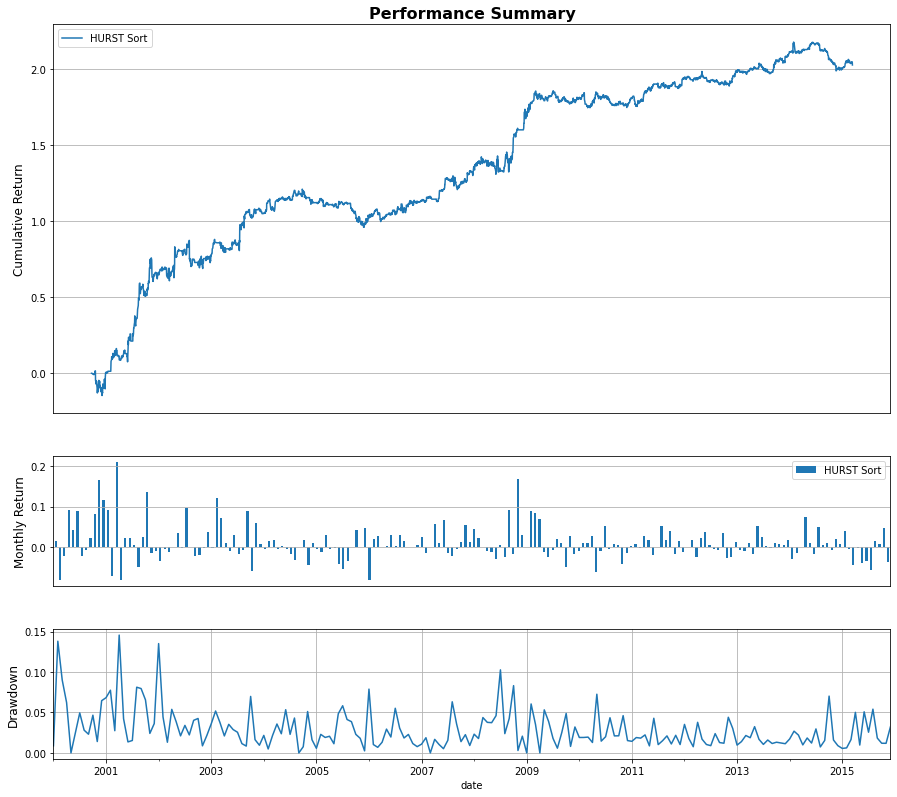

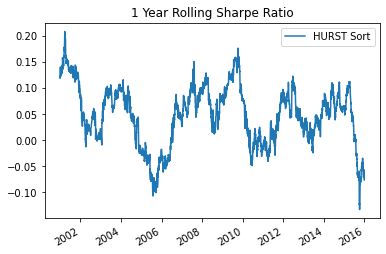

HURST Sort


return    sharpe   sortino  drawdown  turnover  long count  \
year                                                                    
2000     0.494365  1.936841  2.959230  0.156969  0.731879    2.515873   
2001     0.286757  1.059670  1.613569  0.145642  0.653818    2.588710   
2002     0.072448  0.329705  0.385830  0.179485  0.560057    2.202381   
2003     0.293895  1.543249  3.255374  0.077503  0.685228    2.345238   
2004    -0.038326 -0.354433 -0.446845  0.110229  0.557230    2.765873   
2005    -0.030124 -0.283156 -0.415926  0.158730  0.637394    3.126984   
2006     0.054700  0.478394  0.698072  0.078861  0.579944    2.697211   
2007     0.188314  1.529581  2.699836  0.086595  0.524395    2.501992   
2008     0.278110  1.285067  1.766965  0.125240  0.628076    2.600791   
2009     0.191702  1.269095  1.874487  0.072722  0.562876    2.694444   
2010    -0.030113 -0.291248 -0.366549  0.094470  0.689078    2.869048   
2011     0.137551  1.493376  2.232141  0.065864  0.675914    2.702381   
2012     0.014878  0.172262  0.243161  0.067968  0.693732    2.760000   
2013     0.089926  1.179662  1.922466  0.042461  0.667862    3.365079   
2014     0.123787  1.028817  1.818614  0.072945  0.661610    2.523810   
2015    -0.101367 -1.209328 -1.574469  0.172350  0.603165    2.646825   
Overall  2.026505  0.801330  1.134265  0.226886  0.667906    2.681739   

         short count  
year                  
2000        1.515873  
2001        1.588710  
2002        1.202381  
2003        1.345238  
2004        1.765873  
2005        2.126984  
2006        1.697211  
2007        1.501992  
2008        1.600791  
2009        1.694444  
2010        1.869048  
2011        1.702381  
2012        1.760000  
2013        2.365079  
2014        1.523810  
2015        1.646825  
Overall     1.681739

In [118]:
alphas = [HURST_SORT(reset=90, npairs=10, enter=2.25, exit=1.75, stop=3.5, 
                     hurst_cutoff=0.5)]
returns, holdings = backtester_15y.backtest(alphas, processes=None)
metrics.summary_plot(returns, source=['HURST Sort'])
get_rolling_sharpe(returns)
get_analytics(alphas, returns, holdings)

## Hurst Alphas Notes

As the results show, using Hurst indeed seems to increase the profitability of the pairs trading strategy. Sharpe ratio increased in both alphas, but using Hurst exponent as a requirement for a pair to be traded outperformed selecting pairs based on their Hurst exponent.

# Final Model Selection

## Out of Sample Testing - 5 Years

We have selected two alphas to move forward with as our final alphas. We consider our main alpha to be the unoptimized Hurst cutoff alpha, and we are also testing the optimized Testing2 Alpha as we are curious to see how overfitting might affect performance on a validation dataset. 

- Hurst OOS Results
- Optimized Testing2 OOS Results
- Discussion
- Future Work

Finally, recall our out of sample backtester uses market data from the beginning of $2016$ to the end of $2020$.

HURST Cutoff: 100%|█████████████████████████████████████████████████████████████████████| 1/1 [02:08<00:00, 128.02s/it]


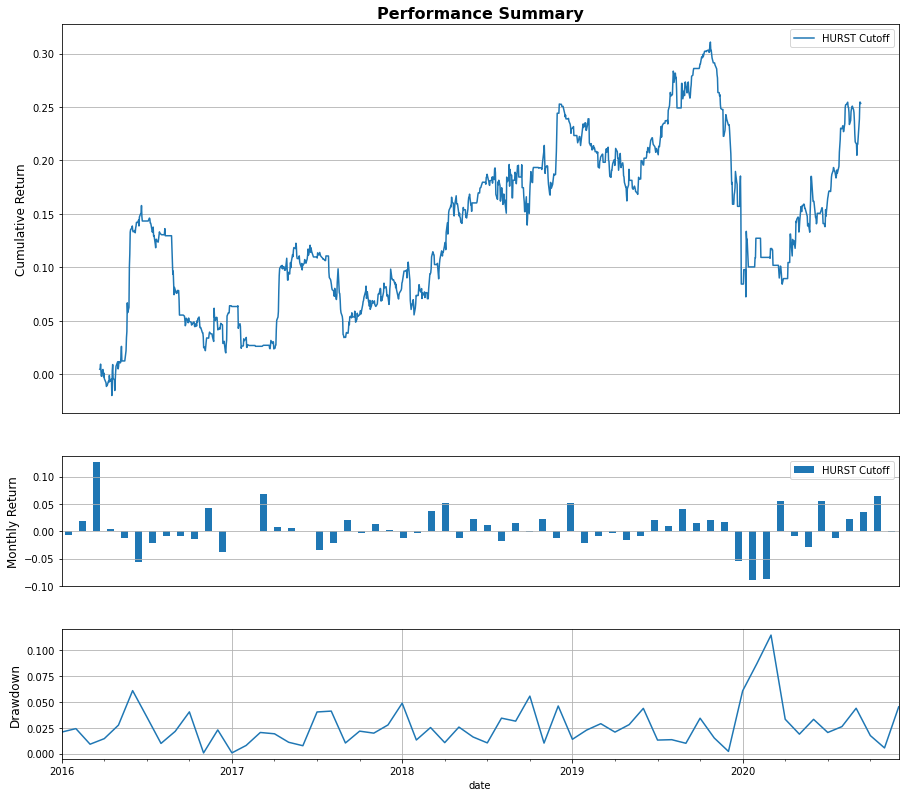

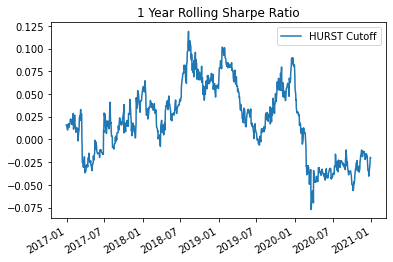

HURST Cutoff


return    sharpe   sortino  drawdown  turnover  long count  \
year                                                                    
2016     0.026879  0.253141  0.349098  0.130746  0.530532    2.591270   
2017     0.059621  0.793945  1.074131  0.085486  0.456358    2.780876   
2018     0.100376  0.881657  1.159129  0.056676  0.759199    2.625498   
2019     0.116236  1.300224  1.952546  0.087959  0.625918    2.638889   
2020    -0.049696 -0.320652 -0.399929  0.216401  0.565589    2.438735   
Overall  0.253417  0.455565  0.588204  0.216401  0.623900    2.614774   

         short count  
year                  
2016        1.591270  
2017        1.780876  
2018        1.625498  
2019        1.638889  
2020        1.438735  
Overall     1.614774

In [11]:
backtester_5y = fb.FullMultipleBacktester.from_local('pairs\pairs_5y.npy')
alphas = [Hurst_Cutoff(reset=90, npairs=10, enter=2.25, exit=1.75,
                       stop=3.5, hurst_cutoff=0.5)]
returns, holdings = backtester_5y.backtest(alphas, processes=None)
metrics.summary_plot(returns, source=['HURST Cutoff'])
get_rolling_sharpe(returns)
get_analytics(alphas, returns, holdings)

3.5 oos - likely final

Testing2: 100%|█████████████████████████████████████████████████████████████████████████| 1/1 [03:52<00:00, 232.26s/it]


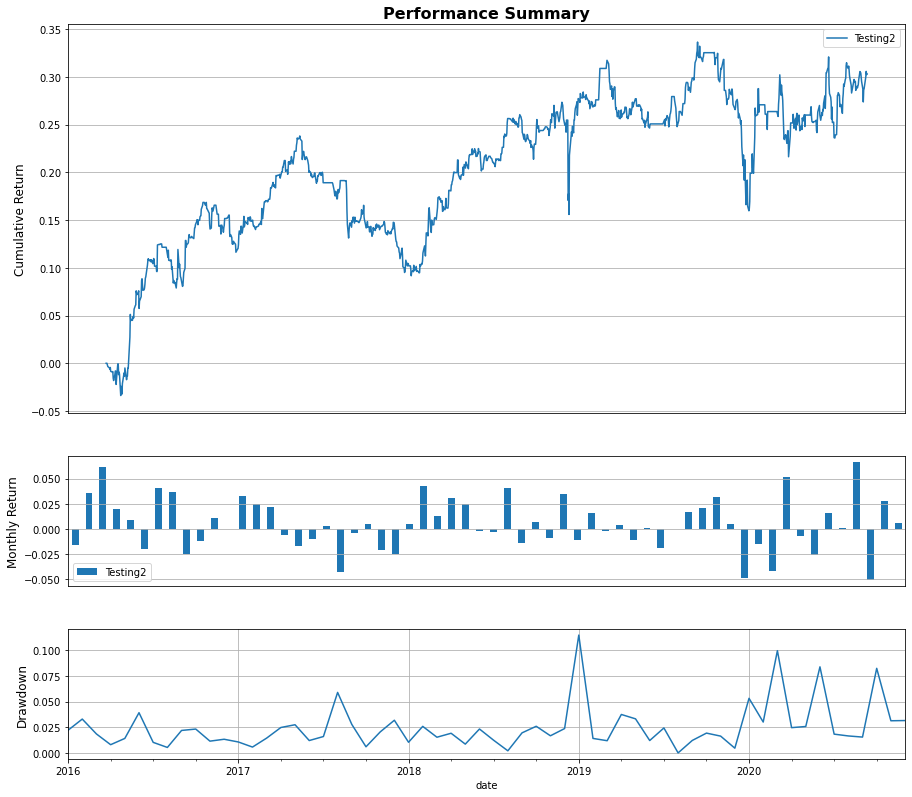

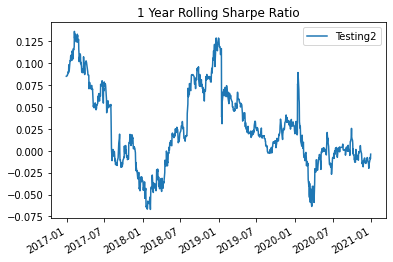

Testing2


return    sharpe   sortino  drawdown  turnover  long count  \
year                                                                    
2016     0.142964  1.352154  1.980501  0.051622  0.595546    3.091270   
2017    -0.040888 -0.545723 -0.658477  0.135031  0.603684    3.430279   
2018     0.171425  2.075764  2.991338  0.045874  0.662387    3.896414   
2019     0.052256  0.380835  0.427864  0.114650  0.497569    2.920635   
2020    -0.022704 -0.138650 -0.177271  0.155412  0.621752    3.280632   
Overall  0.303053  0.514880  0.628966  0.165620  0.634303    3.323272   

         short count  
year                  
2016        2.091270  
2017        2.430279  
2018        2.896414  
2019        1.920635  
2020        2.280632  
Overall     2.323272

In [127]:
from sif.pairstrading.alphas import Testing2
alphas = [Testing2(reset=90, npairs=25, enter=2.0, exit=2.0, stop=3.5)]
returns, holdings = backtester_5y.backtest(alphas, processes=None)
metrics.summary_plot(returns, source=['Testing2'])
get_rolling_sharpe(returns)     
get_analytics(alphas, returns, holdings)

## Results

As we can see, the optimized alpha outperformed the Hurst alpha.

Notably, the Hurst alpha suffered from large drawdown in $2020$.

Overall Performance Notes

1. Poor performance - the S&P500 enormously outperforms pairs trading during the same time period.

2. High Drawdown - with pairs trading, we expect low drawdown, as our trading should be market neutral and relatively low risk. However, we can clearly see that the strategy suffers during certain time periods.

3. Low Sharpe Ratio - as a result of our large drawdown, sharpe suffers significantly as we are exhibiting relatively high risk for relatively low returns.

## Discussion & Problems With This Research

1. Performance

    Altogether, this performance matches our expectations for the pairs trading strategy. Pairs trading is known to be outdated, and its market edge should be gone due to market efficiency. Our research demonstrates that clearly. Despite this, this work serves a great segway into future statistical arbitrage research with other data sources

2. Parameter Optimization

    Similar to previous examples in SIF work, we naively optimized for returns in this notebook. However, optimizing for returns can easily lead to in sample overfitting and that optimizing for sharpe would be better practice moving forward. After all, we are not seeking high returns but instead high risk adjusted returns.
    
3. Struggles with infrastructure

    SIF's infrastructure is designed primarily for portfolio management techniques and a factor-based approach to investing. Implementing pairs trading through our infrastructure required many workarounds and was quite difficult. It will be interesting to implement and check performance on the new HFT platform with signal-based enter/exit conditions.
    
4. Overfitting

    Throughout our research, we iterated over hundreds if not thousands of alphas in order to seek the best performance. With such iteration being naturally optimized on in sample performance, it is apparent that we end up selecting a strategy that performs the best in sample. However, due to the large volume of tested alphas, this methodology is very likely to overfit ion the in sample data, which is a likely reason for our reduction in risk-adjusted returns during the out of sample period. For further research, we would reccomend using a more streamlined research process that clearly defines in sample expecations and final model selection techniques before beginning research and sets a focus on preventing overfitting.

## References

[https://www.investopedia.com/terms/p/pairstrade.asp](https://www.investopedia.com/terms/p/pairstrade.asp)

[https://www.investopedia.com/terms/m/market-neutral-fund.asp](https://www.investopedia.com/terms/m/market-neutral-fund.asp)

[https://en.wikipedia.org/wiki/Long-Term_Capital_Management#Riskier_investments_starting_in_1997](https://en.wikipedia.org/wiki/Long-Term_Capital_Management#Riskier_investments_starting_in_1997)

[https://corporatefinanceinstitute.com/resources/wealth-management/pairs-trading/](https://corporatefinanceinstitute.com/resources/wealth-management/pairs-trading/)

[https://www.fidelity.com/learning-center/trading-investing/trading/pairs-trading](https://www.fidelity.com/learning-center/trading-investing/trading/pairs-trading)

[https://www.investopedia.com/terms/r/relativestrength.asp](https://www.investopedia.com/terms/r/relativestrength.asp)

[https://algotrading101.com/learn/pairs-trading-guide/](https://algotrading101.com/learn/pairs-trading-guide/)

[https://www.quantifiedstrategies.com/pair-trading-strategy/](https://www.quantifiedstrategies.com/pair-trading-strategy/)

[https://hudsonthames.org/an-introduction-to-cointegration/](https://hudsonthames.org/an-introduction-to-cointegration/)

[https://israeldi.github.io/coursework/EECS545/545_Final_Project.pdf](https://israeldi.github.io/coursework/EECS545/545_Final_Project.pdf)

[https://builtin.com/data-science/step-step-explanation-principal-component-analysis](https://builtin.com/data-science/step-step-explanation-principal-component-analysis)

[https://towardsdatascience.com/dbscan-clustering-explained-97556a2ad556](https://towardsdatascience.com/dbscan-clustering-explained-97556a2ad556)

[https://www.statsmodels.org/dev/generated/statsmodels.multivariate.pca.PCA.html](https://www.statsmodels.org/dev/generated/statsmodels.multivariate.pca.PCA.html)

[https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html)

[https://scikit-learn.org/stable/modules/generated/sklearn.cluster.OPTICS.html](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.OPTICS.html)

[https://medium.com/@ashwin8april/dimensionality-reduction-and-visualization-using-pca-principal-component-analysis-8489b46c2ae0](https://medium.com/@ashwin8april/dimensionality-reduction-and-visualization-using-pca-principal-component-analysis-8489b46c2ae0)

[https://www.researchgate.net/publication/305808800_Pairs_Trading_Different_Weights_Methods_and_Markets](https://www.researchgate.net/publication/305808800_Pairs_Trading_Different_Weights_Methods_and_Markets)